## Import tools

In [2]:
# data manipulation
import pandas as pd
from pandas.plotting import table
import numpy as np

# system
import glob
import os

# data visualization
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.cm import get_cmap
matplotlib.rcParams.update({'font.size': 16})

# data analysis
import scipy
from scipy.signal import find_peaks

## Functions

In [92]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

In [33]:
def plotting(path, title, letter_place, fig_name, name_dict, nrows=6, ncols=2, darker = 0.6):
    """
    Function to plot DFT results from Crystal Code. 
    path = string, address of files i. e. 'HZO_112/*.txt' (obs: convert the files using the converting function if needed)
    title = string, title of the graph
    letter_place = integer, configuration position number inside path
    fig_name = string, name of figure to save
    darker = float, to darkent the rainbow colors of the graph lines
    """
    # reading the files from folder
    filenames_HZO = glob.glob(path)
    # putting the files in order
    filenames_HZO.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    # creating figure and axes
    fig, ax = plt.subplots(nrows, ncols, sharex=True)

    # white background to appears in dark jupyter theme
    rect = fig.patch
    rect.set_facecolor('white')

    # empty dict to put the files inside
    name_dict = {}

    # creating a range of colors in rainbow style
    n = len(filenames_HZO)
    colors = cm.rainbow(np.linspace(0, 1, n))

    # itarating over the files, colors and columns fot he figure
    for i, j, z in zip(filenames_HZO, colors, range(len(filenames_HZO))):
        #opening the files with pandas
        config = pd.read_csv(i, delim_whitespace=True, index_col=False, 
                    names=["Frequency", "Wavelength", 
                           "Raw_abs", "Classical_abs", 
                           "Rayleigh_scat1", "Rayleigh_scat2", 
                           "Reflec_x", "Reflec_y", "Reflec_z"], header=None)
        # saving data to dictionary
        name_dict[i[letter_place]] = config[["Frequency", "Raw_abs"]]

        # plotting half of data into the first column of figure
        if z < nrows:
                ax[z,0].plot(config.Frequency[:800], config.Raw_abs[:800], linewidth=2, 
                           label=i[letter_place], 
                           color=adjust_lightness(j, darker))
                ax[z,0].legend()  
                ax[z,0].tick_params(axis='x', direction='in')
                ax[z,0].set_ylim(-5, max(config.Raw_abs[:])+60)
                ax[z,0].set_xlim(0, 800)
                # adding the frequency values to the peaks
                for peak in find_peaks(config.Raw_abs[:])[0]:
        #             print(peak)

                    #annotation
                    ax[z,0].annotate(str(round(config.Frequency[peak])), xytext=(config.Frequency[peak]-10, config.Raw_abs[peak]+15), 
                                     xy=(config.Frequency[peak], config.Raw_abs[peak]), fontsize=10, rotation=90)

        else:
                ax[z-nrows, 1].plot(config.Frequency[:800], config.Raw_abs[:800], linewidth=2, 
                                label=i[letter_place], 
                                color=adjust_lightness(j, darker))
                ax[z-nrows, 1].legend()  
                ax[z-nrows, 1].tick_params(axis='x', direction='in')
                ax[z-nrows, 1].set_ylim(-5, max(config.Raw_abs[:])+60)

                for peak in find_peaks(config.Raw_abs[:])[0]:
                    ax[z-nrows, 1].annotate(str(round(config.Frequency[peak])), xytext=(config.Frequency[peak]-10, config.Raw_abs[peak]+15), 
                                     xy=(config.Frequency[peak], config.Raw_abs[peak]), fontsize=10, rotation=90)


    fig.text(0.45, 0.92, title, fontsize = 17)
    fig.text(0.5, 0.06, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
    fig.text(0.02, 0.5, 'Intensity km/mol', ha='center', va='center', rotation='vertical', fontsize = 17)
    plt.rcParams.update({'font.size': 16})
    fig.set_size_inches(12.5, 20.5)

    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.2, 
                        hspace=0)


    fig.savefig(fig_name, bbox_inches="tight")

### Smoothing Import

In [2]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
#     r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
#     The Savitzky-Golay filter removes high frequency noise from data.
#     It has the advantage of preserving the original shape and
#     features of the signal better than other types of filtering
#     approaches, such as moving averages techniques.
#     Parameters
#     ----------
#     y : array_like, shape (N,)
#         the values of the time history of the signal.
#     window_size : int
#         the length of the window. Must be an odd integer number.
#     order : int
#         the order of the polynomial used in the filtering.
#         Must be less then `window_size` - 1.
#     deriv: int
#         the order of the derivative to compute (default = 0 means only smoothing)
#     Returns
#     -------
#     ys : ndarray, shape (N)
#         the smoothed signal (or it's n-th derivative).
#     Notes
#     -----
#     The Savitzky-Golay is a type of low-pass filter, particularly
#     suited for smoothing noisy data. The main idea behind this
#     approach is to make for each point a least-square fit with a
#     polynomial of high order over a odd-sized window centered at
#     the point.
#     Examples
#     --------
#     t = np.linspace(-4, 4, 500)
#     y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
#     ysg = savitzky_golay(y, window_size=31, order=4)
#     import matplotlib.pyplot as plt
#     plt.plot(t, y, label='Noisy signal')
#     plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
#     plt.plot(t, ysg, 'r', label='Filtered signal')
#     plt.legend()
#     plt.show()
#     References
#     ----------
#     .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
#        Data by Simplified Least Squares Procedures. Analytical
#        Chemistry, 1964, 36 (8), pp 1627-1639.
#     .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
#        W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
#        Cambridge University Press ISBN-13: 9780521880688
#     """
    from math import factorial
    
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except ValueError as msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

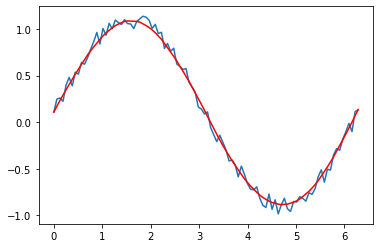

<Figure size 432x288 with 0 Axes>

In [3]:
x = np.linspace(0,2*np.pi,100)
y = np.sin(x) + np.random.random(100) * 0.2
yhat = savitzky_golay(y, 51, 3) # window size 51, polynomial order 3

plt.plot(x,y)
plt.plot(x,yhat, color='red')
plt.figure()
plt.show()

In [4]:
import nbformat as nbf
# from glob import glob

import uuid
def get_cell_id(id_length=8):
    return uuid.uuid4().hex[:id_length]

# your notebook name/keyword
nb_name = 'my_notebook'
notebooks = list(filter(lambda x: nb_name in x, glob.glob("./*.ipynb", recursive=True)))

# iterate over notebooks
for ipath in sorted(notebooks):
    # load notebook
    ntbk = nbf.read(ipath, nbf.NO_CONVERT)
    
    cell_ids = []
    for cell in ntbk.cells:
        cell_ids.append(cell['id'])

    # reset cell ids if there are duplicates
    if not len(cell_ids) == len(set(cell_ids)): 
        for cell in ntbk.cells:
            cell['id'] = get_cell_id()

        nbf.write(ntbk, ipath)

## Converting files extentions

In [6]:
# filenames_HZO211 = glob.glob('HZO_211/*.irspec')
# # filenames_HZO211
# for file in filenames_HZO211:
#     base = os.path.splitext(file)[0]
#     os.rename(file, base + ".txt")

# filenames_txt = glob.glob('*.txt')

In [40]:
# filenames_HZO112 = glob.glob('HZO_112/*.irspec')
# # filenames_HZO211
# for file in filenames_HZO112:
#     base = os.path.splitext(file)[0]
#     os.rename(file, base + ".txt")

# filenames_txt = glob.glob('*.txt')

In [5]:
# filenames_HZO121 = glob.glob('HZO_121/*.irspec')
# # filenames_HZO211
# for file in filenames_HZO121:
#     base = os.path.splitext(file)[0]
#     os.rename(file, base + ".txt")

# filenames_txt = glob.glob('*.txt')

## Theory behind the weighted average of multiple IR spectra using the supercell method

The final theoretical IR spectrum, with intensity $\bar{I}_N(\nu,T)$, can be obtained from a weighted average over all the spectra, $I_i\left(\nu\right)$, corresponding to each of the $N = 14$ (HZO 121), $N = 12$ (HZO 112) and $N = 13$ (HZO 211) configurations in the orthorhombic (space group 29) geometry following:

\begin{equation}
  \bar{I}_N\left(\nu,T\right)=\sum_{i=1}^{N}{P_i\left(V,T\right) \times {I_i}\left(\nu\right)}
\label{eq1}
\end{equation}


and by using the Boltzmann occupation probability, $P_i\left(V,T\right)$, given by:


\begin{equation}
  {P_i}\left(V,T\right)=\frac{m_i\exp{\left(-\frac{E_i}{k_BT}\right)}}{\mathrm{\Omega}}\;\;\text{ with }\;\;{\Omega}=\sum_{i=1}^{N}{{m_i}\exp\left(-\frac{E_i}{k_BT}\right)}. 
\label{eq2}
\end{equation}

## HZO 121 DFT

### Plotting all configurations (non-normalized)

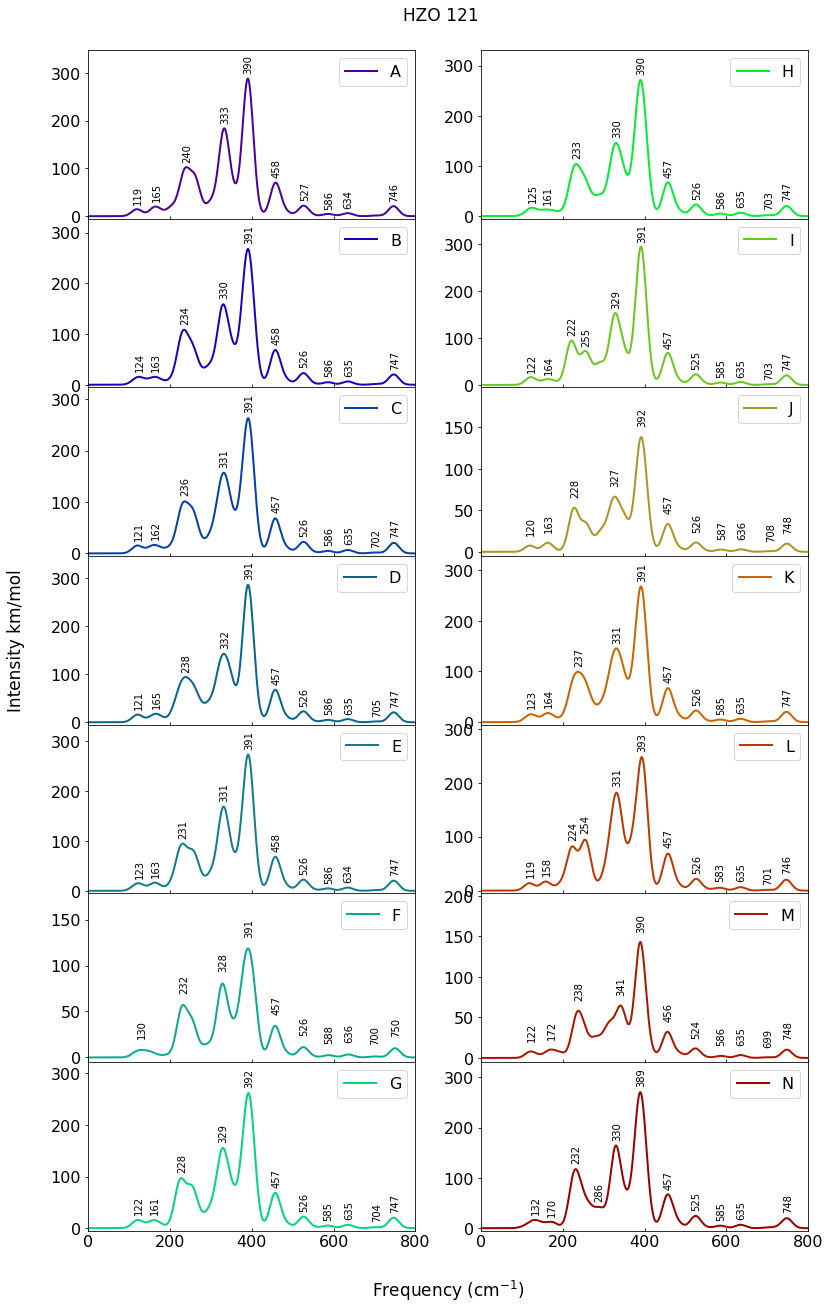

In [6]:
plotting('HZO_121/*.txt', "HZO 121", 16, 'HZO_121', "HZO_121_DFT_IR.png", nrows=7, ncols=2)

### Calculating and plotting the average
supercell 1x2x1 :  

B - 8 ; C - 8 ; D - 8 ; E - 8 ; G - 8; H - 8 ; K - 8 ;

A - 2 ; F - 2 ;  I - 2 ; J - 2 ;  L - 2 ; M - 2 ; N - 2

#### Populations are calculated in the notebook 
http://localhost:8888/notebooks/OneDrive/Python/HZO/Params_extraction/extracting_params_out_DFT_file.ipynb

#### $T = 300 K$

In [120]:
# opening populations coming from another notebook 
df_HZO_121_populations = pd.read_csv("energies_population_HZO_121.csv")
df_HZO_121_populations

,Unnamed: 0,normalized_population,normalized_population %
0,HZO_121_A,0.027306,2.730641
1,HZO_121_B,0.113169,11.316924
2,HZO_121_C,0.110870,11.087007
3,HZO_121_D,0.112274,11.227379
4,HZO_121_E,0.110835,11.083499
5,HZO_121_F,0.028488,2.848811
6,HZO_121_G,0.110666,11.066620
7,HZO_121_H,0.114647,11.464715
8,HZO_121_I,0.033319,3.331880
9,HZO_121_J,0.032591,3.259056


In [126]:
# listing all files to plot
filenames_HZO_121 = glob.glob('HZO_121/*.txt')
# sort them by alphabetical order
filenames_HZO_121.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

# # white background to appears in dark jupyter theme
# fig, ax = plt.subplots(nrows=len(filenames_HZO_121), ncols=1, figsize=(6,35))
# rect = fig.patch
# rect.set_facecolor('white')

# empty dictionary to add the normalized data
d_HZO_121_pop = {}

# iterate over the list of files to plot and the population of each config to be multiplied
for i, population in zip(filenames_HZO_121, df_HZO_121_populations["normalized_population %"]):
#     print(i, population)
    # opens the spectrm file of one config
    config = pd.read_csv(i, delim_whitespace=True, index_col=False, 
                names=["Frequency", "Wavelength", 
                       "Raw_abs", "Classical_abs", 
                       "Rayleigh_scat1", "Rayleigh_scat2", 
                       "Reflec_x", "Reflec_y", "Reflec_z"], header=None)
    # calculates the weight of this config
    config["Raw_abs"] = config.Raw_abs*population
    # saves this config inside the dict
    d_HZO_121_pop[i[16]] = config[["Frequency", "Raw_abs"]]

In [127]:
d_HZO_121_pop

{'A':       Frequency       Raw_abs
 0         0.001  9.385376e-12
 1         1.001  1.593580e-11
 2         2.001  2.689181e-11
 3         3.001  4.510145e-11
 4         4.001  7.517700e-11
 ...         ...           ...
 1204   1204.000  0.000000e+00
 1205   1205.000  0.000000e+00
 1206   1206.000  0.000000e+00
 1207   1207.000  0.000000e+00
 1208   1208.000  0.000000e+00
 
 [1209 rows x 2 columns],
 'B':       Frequency       Raw_abs
 0         0.001  2.218411e-11
 1         1.001  3.749478e-11
 2         2.001  6.298525e-11
 3         3.001  1.051597e-10
 4         4.001  1.745036e-10
 ...         ...           ...
 1205   1205.000  0.000000e+00
 1206   1206.000  0.000000e+00
 1207   1207.000  0.000000e+00
 1208   1208.000  0.000000e+00
 1209   1209.000  0.000000e+00
 
 [1210 rows x 2 columns],
 'C':       Frequency       Raw_abs
 0         0.001  8.965863e-12
 1         1.001  1.533688e-11
 2         2.001  2.607409e-11
 3         3.001  4.405655e-11
 4         4.001  7.398460e-11

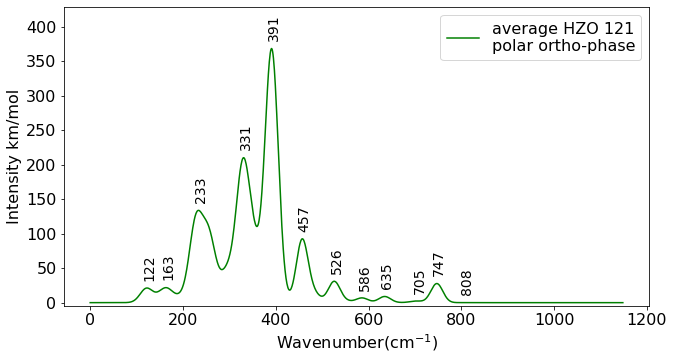

In [128]:
# Calculating the average of all configs
# empty lists to add intensity and frequency values to sum
Int_all = []
wvn_all = []

# iterate over the configs
for k in d_HZO_121_pop.keys():
    # adds the frequencies to an empty list
    wvn_all.append(d_HZO_121_pop[k]['Frequency'])
    # adds the intensities to an empty list
    Int_all.append(d_HZO_121_pop[k]['Raw_abs'])

# total weight of all configurations is 70        
Int_Average_HZO_121 = sum(Int_all)/70
wvn_Average_HZO_121 = sum(wvn_all)/len(wvn_all)

# create figure and axes
fig, ax = plt.subplots()

# white background to appears in dark jupyter theme
rect = fig.patch
rect.set_facecolor('white')

# matplotlib.rcParams.update({'font.size': 18})
# plotting
ax.plot(wvn_Average_HZO_121, Int_Average_HZO_121, c='green', 
         label='average HZO 121\npolar ortho-phase')
ax.legend(fontsize=16)
ax.set_xlabel('Wavenumber(cm$^{-1}$)', fontsize=16)
ax.set_ylabel('Intensity km/mol', fontsize=16)
ax.set_ylim(-5, max(Int_Average_HZO_121)+60)

# adding frequency values to peaks iteratively
for peak in find_peaks(Int_Average_HZO_121)[0]:
    ax.annotate(str(round(wvn_Average_HZO_121[peak])), 
                xytext=(wvn_Average_HZO_121[peak]-10, Int_Average_HZO_121[peak]+15), 
                xy=(wvn_Average_HZO_121[peak], Int_Average_HZO_121[peak]), 
                fontsize=14, rotation=90) 

fig.set_size_inches(10.5, 5.5)
fig.savefig("Average_HZO121_sp29.png", bbox_inches="tight")

#### $T = 723.15 K$

In [38]:
# opening populations coming from another notebook 
df_HZO_121_populations_723 = pd.read_csv("energies_population_HZO_121_723.csv")
df_HZO_121_populations_723

,Unnamed: 0,Energy (AU),energy_joule,energy_meV,distr_Boltz,population,normalized_population
0,HZO_121_A,-198.166086,7.229417e-22,4.512,0.930,0.027,2.818
1,HZO_121_B,-198.166111,6.127597e-22,3.825,0.940,0.107,11.398
2,HZO_121_C,-198.166097,6.765210e-22,4.223,0.934,0.107,11.325
3,HZO_121_D,-198.166106,6.374373e-22,3.979,0.938,0.107,11.370
4,HZO_121_E,-198.166097,6.775043e-22,4.229,0.934,0.107,11.324
5,HZO_121_F,-198.166116,5.913356e-22,3.691,0.942,0.027,2.856
6,HZO_121_G,-198.166095,6.822387e-22,4.258,0.934,0.107,11.319
7,HZO_121_H,-198.166121,5.724541e-22,3.573,0.944,0.108,11.444
8,HZO_121_I,-198.166228,1.047545e-22,0.654,0.990,0.028,2.998
9,HZO_121_J,-198.166212,1.734053e-22,1.082,0.983,0.028,2.978


In [39]:
# listing all files to plot
filenames_HZO_121 = glob.glob('HZO_121/*.txt')
# sort them by alphabetical order
filenames_HZO_121.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

# # white background to appears in dark jupyter theme
# fig, ax = plt.subplots(nrows=len(filenames_HZO_121), ncols=1, figsize=(6,35))
# rect = fig.patch
# rect.set_facecolor('white')

# empty dictionary to add the normalized data
d_HZO_121_pop_723 = {}

# iterate over the list of files to plot and the population of each config to be multiplied
for i, population in zip(filenames_HZO_121, df_HZO_121_populations_723["normalized_population"]):
#     print(i, population)
    # opens the spectrm file of one config
    config = pd.read_csv(i, delim_whitespace=True, index_col=False, 
                names=["Frequency", "Wavelength", 
                       "Raw_abs", "Classical_abs", 
                       "Rayleigh_scat1", "Rayleigh_scat2", 
                       "Reflec_x", "Reflec_y", "Reflec_z"], header=None)
    # calculates the weight of this config
    config["Raw_abs"] = config.Raw_abs*population
    # saves this config inside the dict
    d_HZO_121_pop_723[i[16]] = config[["Frequency", "Raw_abs"]]
d_HZO_121_pop_723

{'A':       Frequency       Raw_abs
 0         0.001  9.685635e-12
 1         1.001  1.644562e-11
 2         2.001  2.775214e-11
 3         3.001  4.654434e-11
 4         4.001  7.758208e-11
 ...         ...           ...
 1204   1204.000  0.000000e+00
 1205   1205.000  0.000000e+00
 1206   1206.000  0.000000e+00
 1207   1207.000  0.000000e+00
 1208   1208.000  0.000000e+00
 
 [1209 rows x 2 columns],
 'B':       Frequency       Raw_abs
 0         0.001  2.234304e-11
 1         1.001  3.776340e-11
 2         2.001  6.343648e-11
 3         3.001  1.059131e-10
 4         4.001  1.757537e-10
 ...         ...           ...
 1205   1205.000  0.000000e+00
 1206   1206.000  0.000000e+00
 1207   1207.000  0.000000e+00
 1208   1208.000  0.000000e+00
 1209   1209.000  0.000000e+00
 
 [1210 rows x 2 columns],
 'C':       Frequency       Raw_abs
 0         0.001  9.158324e-12
 1         1.001  1.566610e-11
 2         2.001  2.663380e-11
 3         3.001  4.500227e-11
 4         4.001  7.557274e-11

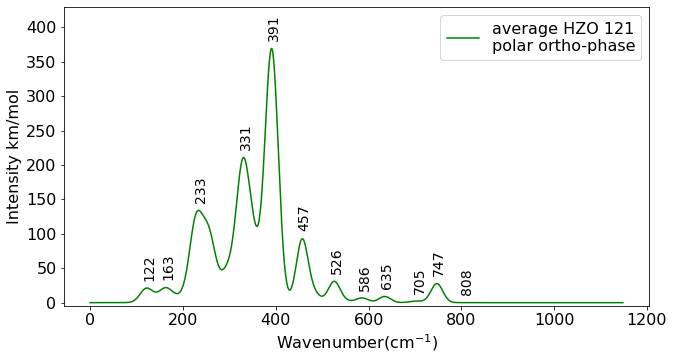

In [40]:
# Calculating the average of all configs
# empty lists to add intensity and frequency values to sum
Int_all = []
wvn_all = []

# iterate over the configs
for k in d_HZO_121_pop_723.keys():
    # adds the frequencies to an empty list
    wvn_all.append(d_HZO_121_pop_723[k]['Frequency'])
    # adds the intensities to an empty list
    Int_all.append(d_HZO_121_pop_723[k]['Raw_abs'])

# total weight of all configurations is 70        
Int_Average_HZO_121 = sum(Int_all)/70
wvn_Average_HZO_121 = sum(wvn_all)/len(wvn_all)

# create figure and axes
fig, ax = plt.subplots()

# white background to appears in dark jupyter theme
rect = fig.patch
rect.set_facecolor('white')

# matplotlib.rcParams.update({'font.size': 18})
# plotting
ax.plot(wvn_Average_HZO_121, Int_Average_HZO_121, c='green', 
         label='average HZO 121\npolar ortho-phase')
ax.legend(fontsize=16)
ax.set_xlabel('Wavenumber(cm$^{-1}$)', fontsize=16)
ax.set_ylabel('Intensity km/mol', fontsize=16)
ax.set_ylim(-5, max(Int_Average_HZO_121)+60)

# adding frequency values to peaks iteratively
for peak in find_peaks(Int_Average_HZO_121)[0]:
    ax.annotate(str(round(wvn_Average_HZO_121[peak])), 
                xytext=(wvn_Average_HZO_121[peak]-10, Int_Average_HZO_121[peak]+15), 
                xy=(wvn_Average_HZO_121[peak], Int_Average_HZO_121[peak]), 
                fontsize=14, rotation=90) 

fig.set_size_inches(10.5, 5.5)
fig.savefig("Average_HZO121_sp29_723K.png", bbox_inches="tight")

### Plottting all configurations - normalized using the populations

In [129]:
d_HZO_121_pop

{'A':       Frequency       Raw_abs
 0         0.001  9.385376e-12
 1         1.001  1.593580e-11
 2         2.001  2.689181e-11
 3         3.001  4.510145e-11
 4         4.001  7.517700e-11
 ...         ...           ...
 1204   1204.000  0.000000e+00
 1205   1205.000  0.000000e+00
 1206   1206.000  0.000000e+00
 1207   1207.000  0.000000e+00
 1208   1208.000  0.000000e+00
 
 [1209 rows x 2 columns],
 'B':       Frequency       Raw_abs
 0         0.001  2.218411e-11
 1         1.001  3.749478e-11
 2         2.001  6.298525e-11
 3         3.001  1.051597e-10
 4         4.001  1.745036e-10
 ...         ...           ...
 1205   1205.000  0.000000e+00
 1206   1206.000  0.000000e+00
 1207   1207.000  0.000000e+00
 1208   1208.000  0.000000e+00
 1209   1209.000  0.000000e+00
 
 [1210 rows x 2 columns],
 'C':       Frequency       Raw_abs
 0         0.001  8.965863e-12
 1         1.001  1.533688e-11
 2         2.001  2.607409e-11
 3         3.001  4.405655e-11
 4         4.001  7.398460e-11

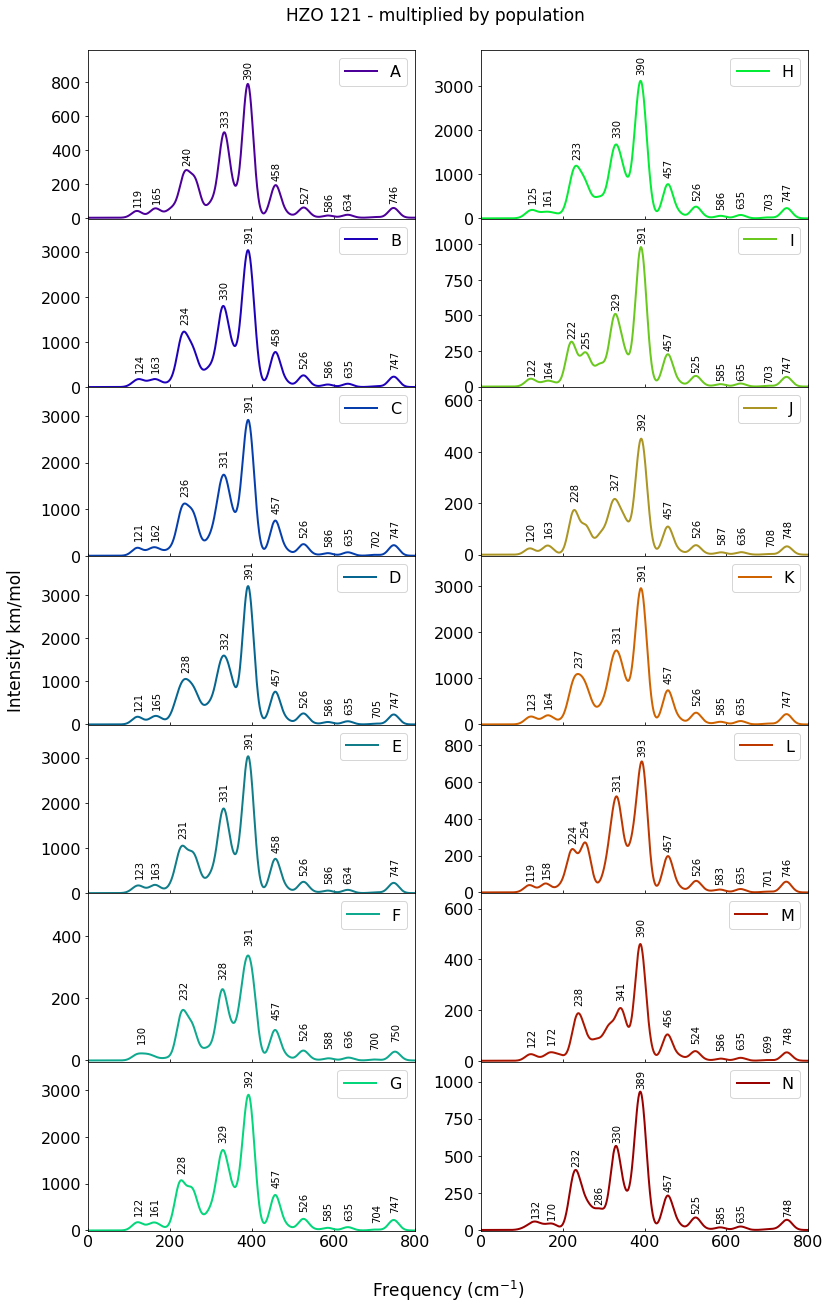

In [130]:
nrows=7
ncols=2
darker=0.6

# creating figure and axes
fig, ax = plt.subplots(nrows, ncols, sharex=True)

# white background to appears in dark jupyter theme
rect = fig.patch
rect.set_facecolor('white')

# creating a range of colors in rainbow style
n = len(d_HZO_121_pop)
colors = cm.rainbow(np.linspace(0, 1, n))

# itarating over the files, colors and columns fot he figure
for i, j, z in zip(d_HZO_121_pop.keys(), colors, range(len(d_HZO_121_pop))):
    # plotting half of data into the first column of figure and half into the second column
    if z < nrows:
        rows = z
        col = 0
    else:
        rows = z-nrows
        col = 1
        
    ax[rows,col].plot(d_HZO_121_pop[i].Frequency[:800], d_HZO_121_pop[i].Raw_abs[:800], linewidth=2, 
               label=i, 
               color=adjust_lightness(j, darker))
    ax[rows,col].legend()  
    ax[rows,col].tick_params(axis='x', direction='in')

    if max(d_HZO_121_pop[i].Raw_abs[:]) > 2000:
        ax[rows,col].set_ylim(-5, max(d_HZO_121_pop[i].Raw_abs[:])+700)
    if max(d_HZO_121_pop[i].Raw_abs[:]) < 2000:
        ax[rows,col].set_ylim(-5, max(d_HZO_121_pop[i].Raw_abs[:])+200)

    ax[rows,col].set_xlim(0, 800)
    # adding the frequency values to the peaks
    for peak in find_peaks(d_HZO_121_pop[i].Raw_abs[:])[0]:
        # annotation of the peak frequencies
        if max(d_HZO_121_pop[i].Raw_abs[:]) > 2000:
            shift = 200
        if max(d_HZO_121_pop[i].Raw_abs[:]) < 2000:
            shift = 40    
        ax[rows,col].annotate(str(round(d_HZO_121_pop[i].Frequency[peak])), 
                         xytext=(d_HZO_121_pop[i].Frequency[peak]-10, d_HZO_121_pop[i].Raw_abs[peak]+shift), 
                         xy=(d_HZO_121_pop[i].Frequency[peak], d_HZO_121_pop[i].Raw_abs[peak]), 
                         fontsize=10, rotation=90)
        

fig.text(0.32, 0.92, "HZO 121 - multiplied by population", fontsize = 17)
fig.text(0.5, 0.06, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.02, 0.5, 'Intensity km/mol', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(12.5, 20.5)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0)


fig.savefig("HZO_121_DFT_IR_populations.png", bbox_inches="tight")

### Plottting all configurations - normalized using only the number of atoms in unit cell

In [43]:
# listing all files to plot
filenames_HZO_121 = glob.glob('HZO_121/*.txt')
# sort them by alphabetical order
filenames_HZO_121.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

# # white background to appears in dark jupyter theme
# fig, ax = plt.subplots(nrows=len(filenames_HZO_121), ncols=1, figsize=(6,35))
# rect = fig.patch
# rect.set_facecolor('white')

# empty dictionary to add the normalized data
d_HZO_121 = {}

# only 12 atoms in unit cell, not 24 as the others
non_norm = ["F", "J", "M"]

# iterate over the list of files to plot 
for i in filenames_HZO_121:
    # opens the spectrm file of one config
    config = pd.read_csv(i, delim_whitespace=True, index_col=False, 
                names=["Frequency", "Wavelength", 
                       "Raw_abs", "Classical_abs", 
                       "Rayleigh_scat1", "Rayleigh_scat2", 
                       "Reflec_x", "Reflec_y", "Reflec_z"], header=None)
    if i[16] in non_norm:
        # calculates the weight of this config
        config["Raw_abs"] = config["Raw_abs"]*2
    else:
        config["Raw_abs"] = config["Raw_abs"]
    # saves this config inside the dict
    d_HZO_121[i[16]] = config[["Frequency", "Raw_abs"]]

In [44]:
d_HZO_121

{'A':       Frequency       Raw_abs
 0         0.001  3.437060e-12
 1         1.001  5.835920e-12
 2         2.001  9.848170e-12
 3         3.001  1.651680e-11
 4         4.001  2.753090e-11
 ...         ...           ...
 1204   1204.000  0.000000e+00
 1205   1205.000  0.000000e+00
 1206   1206.000  0.000000e+00
 1207   1207.000  0.000000e+00
 1208   1208.000  0.000000e+00
 
 [1209 rows x 2 columns],
 'B':       Frequency       Raw_abs
 0         0.001  1.960260e-12
 1         1.001  3.313160e-12
 2         2.001  5.565580e-12
 3         3.001  9.292250e-12
 4         4.001  1.541970e-11
 ...         ...           ...
 1205   1205.000  0.000000e+00
 1206   1206.000  0.000000e+00
 1207   1207.000  0.000000e+00
 1208   1208.000  0.000000e+00
 1209   1209.000  0.000000e+00
 
 [1210 rows x 2 columns],
 'C':       Frequency       Raw_abs
 0         0.001  8.086820e-13
 1         1.001  1.383320e-12
 2         2.001  2.351770e-12
 3         3.001  3.973710e-12
 4         4.001  6.673090e-12

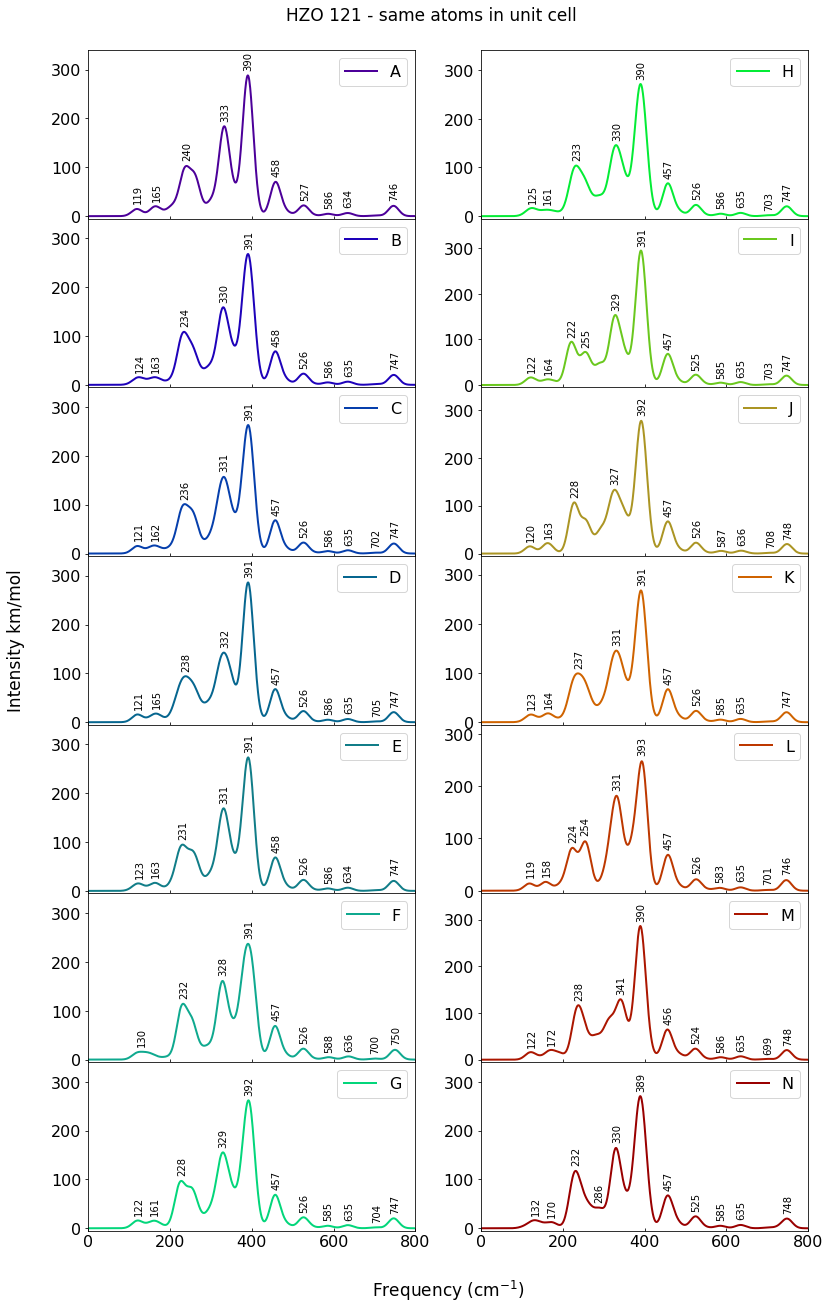

In [45]:
# Plotting HZO 121 using the number of atoms in unit cell
nrows=7
ncols=2
darker=0.6

# creating figure and axes
fig, ax = plt.subplots(nrows, ncols, sharex=True)

# white background to appears in dark jupyter theme
rect = fig.patch
rect.set_facecolor('white')

# creating a range of colors in rainbow style
n = len(d_HZO_121)
colors = cm.rainbow(np.linspace(0, 1, n))

# iterating over the files, colors and columns for the figure
for i, j, z in zip(d_HZO_121.keys(), colors, range(len(d_HZO_121))):
    # plotting half of data into the first column of figure
    if z < nrows:
            ax[z,0].plot(d_HZO_121[i].Frequency[:800], d_HZO_121[i].Raw_abs[:800], linewidth=2, 
                       label=i, 
                       color=adjust_lightness(j, darker))
            ax[z,0].legend()  
            ax[z,0].tick_params(axis='x', direction='in')
            ax[z,0].set_ylim(-5, max(config.Raw_abs[:])+70)
            ax[z,0].set_xlim(0, 800)
            # adding the frequency values to the peaks
            for peak in find_peaks(d_HZO_121[i].Raw_abs[:])[0]:
    #             print(peak)

                #annotation
                ax[z,0].annotate(str(round(d_HZO_121[i].Frequency[peak])), xytext=(d_HZO_121[i].Frequency[peak]-10, d_HZO_121[i].Raw_abs[peak]+15), 
                                 xy=(d_HZO_121[i].Frequency[peak], d_HZO_121[i].Raw_abs[peak]), fontsize=10, rotation=90)

    else:
            ax[z-nrows, 1].plot(d_HZO_121[i].Frequency[:800], d_HZO_121[i].Raw_abs[:800], linewidth=2, 
                            label=i, 
                            color=adjust_lightness(j, darker))
            ax[z-nrows, 1].legend()  
            ax[z-nrows, 1].tick_params(axis='x', direction='in')
            ax[z-nrows, 1].set_ylim(-5, max(d_HZO_121[i].Raw_abs[:])+70)

            for peak in find_peaks(d_HZO_121[i].Raw_abs[:])[0]:
                ax[z-nrows, 1].annotate(str(round(d_HZO_121[i].Frequency[peak])), xytext=(d_HZO_121[i].Frequency[peak]-10, d_HZO_121[i].Raw_abs[peak]+15), 
                                 xy=(d_HZO_121[i].Frequency[peak], d_HZO_121[i].Raw_abs[peak]), fontsize=10, rotation=90)


fig.text(0.32, 0.92, "HZO 121 - same atoms in unit cell", fontsize = 17)
fig.text(0.5, 0.06, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.02, 0.5, 'Intensity km/mol', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(12.5, 20.5)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0)


fig.savefig("HZO_121_DFT_IR_atoms_unit_cell.png", bbox_inches="tight")

## HZO 211 DFT

### Calculating and plotting the average
supercell 2x1x1 : 

A - 4 ; E - 4 ; L - 4 ; H - 4 ; 

B - 8 ; C - 8 ; D - 8 ; F - 8 ; G - 8; K - 8 ; 

I - 2 ; J - 2 ; M - 2



#### $T = 300 K$

In [131]:
# opening populations coming from another notebook 
df_HZO_211_populations = pd.read_csv("energies_population_HZO_211.csv")
df_HZO_211_populations

,Unnamed: 0,normalized_population,normalized_population %
0,HZO_211_A,0.055175,5.517516
1,HZO_211_B,0.088484,8.848386
2,HZO_211_C,0.088902,8.890220
3,HZO_211_D,0.086489,8.648861
4,HZO_211_E,0.055795,5.579518
5,HZO_211_F,0.089572,8.957229
6,HZO_211_G,0.088881,8.888076
7,HZO_211_H,0.056807,5.680715
8,HZO_211_I,0.119244,11.924403
9,HZO_211_J,0.004474,0.447427


In [132]:
# listing all files to plot
filenames_HZO_211 = glob.glob('HZO_211/*.txt')
# sort them by alphabetical order
filenames_HZO_211.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

# # white background to appears in dark jupyter theme
# fig, ax = plt.subplots(nrows=len(filenames_HZO_211), ncols=1, figsize=(6,35))
# rect = fig.patch
# rect.set_facecolor('white')

# empty dictionary to add the normalized data
d_HZO_211_pop = {}

# iterate over the list of files to plot and the population of each config to be multiplied
for i, population in zip(filenames_HZO_211, df_HZO_211_populations["normalized_population %"]):
#     print(i, population)
    # opens the spectrm file of one config
    config = pd.read_csv(i, delim_whitespace=True, index_col=False, 
                names=["Frequency", "Wavelength", 
                       "Raw_abs", "Classical_abs", 
                       "Rayleigh_scat1", "Rayleigh_scat2", 
                       "Reflec_x", "Reflec_y", "Reflec_z"], header=None)
    # calculates the weight of this config
    config["Raw_abs"] = config.Raw_abs*population
    # saves this config inside the dict
    d_HZO_211_pop[i[16]] = config[["Frequency", "Raw_abs"]]

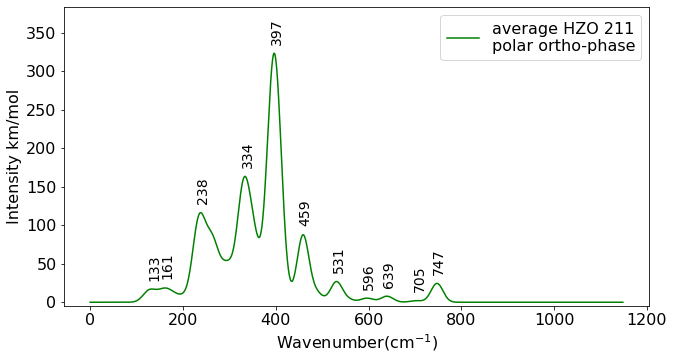

In [133]:
# Calculating the average of all configs
# empty lists to add intensity and frequency values to sum
Int_all = []
wvn_all = []

# iterate over the configs
for k in d_HZO_211_pop.keys():
    # adds the frequencies to an empty list
    wvn_all.append(d_HZO_211_pop[k]['Frequency'])
    # adds the intensities to an empty list
    Int_all.append(d_HZO_211_pop[k]['Raw_abs'])

# total weight of all configurations is 70        
Int_Average_HZO_211 = sum(Int_all)/70
wvn_Average_HZO_211 = sum(wvn_all)/len(wvn_all)

# create figure and axes
fig, ax = plt.subplots()

# white background to appears in dark jupyter theme
rect = fig.patch
rect.set_facecolor('white')

# matplotlib.rcParams.update({'font.size': 18})
# plotting
ax.plot(wvn_Average_HZO_211, Int_Average_HZO_211, c='green', 
         label='average HZO 211\npolar ortho-phase')
ax.legend(fontsize=16)
ax.set_xlabel('Wavenumber(cm$^{-1}$)', fontsize=16)
ax.set_ylabel('Intensity km/mol', fontsize=16)
ax.set_ylim(-5, max(Int_Average_HZO_211)+60)

# adding frequency values to peaks iteratively
for peak in find_peaks(Int_Average_HZO_211)[0]:
    ax.annotate(str(round(wvn_Average_HZO_211[peak])), 
                xytext=(wvn_Average_HZO_211[peak]-10, Int_Average_HZO_211[peak]+15), 
                xy=(wvn_Average_HZO_211[peak], Int_Average_HZO_211[peak]), 
                fontsize=14, rotation=90) 

fig.set_size_inches(10.5, 5.5)
fig.savefig("Average_HZO211_sp29.png", bbox_inches="tight")

#### $T = 723.15 K$

In [49]:
# opening populations coming from another notebook 
df_HZO_211_populations_723 = pd.read_csv("energies_population_HZO_211_723.csv")
df_HZO_211_populations_723

,Unnamed: 0,Energy (AU),energy_joule,energy_meV,distr_Boltz,population,normalized_population
0,HZO_211_A,-1588.397368,1.926306e-21,12.023,0.825,0.047,6.244
1,HZO_211_B,-1588.396110,7.414547e-21,46.278,0.476,0.054,7.207
2,HZO_211_C,-1588.396137,7.297327e-21,45.546,0.481,0.055,7.292
3,HZO_211_D,-1588.395980,7.981348e-21,49.816,0.450,0.051,6.809
4,HZO_211_E,-1588.397432,1.648595e-21,10.290,0.848,0.048,6.420
5,HZO_211_F,-1588.396179,7.110713e-21,44.382,0.491,0.056,7.430
6,HZO_211_G,-1588.396135,7.303322e-21,45.584,0.481,0.055,7.288
7,HZO_211_H,-1588.397535,1.201892e-21,7.502,0.887,0.051,6.714
8,HZO_211_I,-1588.397810,0.000000e+00,0.000,1.000,0.114,15.145
9,HZO_211_J,-1588.379097,8.158383e-20,509.206,0.000,0.000,0.004


In [50]:
# listing all files to plot
filenames_HZO_211 = glob.glob('HZO_211/*.txt')
# sort them by alphabetical order
filenames_HZO_211.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

# # white background to appears in dark jupyter theme
# fig, ax = plt.subplots(nrows=len(filenames_HZO_211), ncols=1, figsize=(6,35))
# rect = fig.patch
# rect.set_facecolor('white')

# empty dictionary to add the normalized data
d_HZO_211_pop_723 = {}

# iterate over the list of files to plot and the population of each config to be multiplied
for i, population in zip(filenames_HZO_211, df_HZO_211_populations_723["normalized_population"]):
#     print(i, population)
    # opens the spectrm file of one config
    config = pd.read_csv(i, delim_whitespace=True, index_col=False, 
                names=["Frequency", "Wavelength", 
                       "Raw_abs", "Classical_abs", 
                       "Rayleigh_scat1", "Rayleigh_scat2", 
                       "Reflec_x", "Reflec_y", "Reflec_z"], header=None)
    # calculates the weight of this config
    config["Raw_abs"] = config.Raw_abs*population
    # saves this config inside the dict
    d_HZO_211_pop_723[i[16]] = config[["Frequency", "Raw_abs"]]
d_HZO_211_pop_723

{'A':       Frequency       Raw_abs
 0         0.001  3.184365e-13
 1         1.001  5.631295e-13
 2         2.001  9.897739e-13
 3         3.001  1.729039e-12
 4         4.001  3.002040e-12
 ...         ...           ...
 1144   1144.000  0.000000e+00
 1145   1145.000  0.000000e+00
 1146   1146.000  0.000000e+00
 1147   1147.000  0.000000e+00
 1148   1148.000  0.000000e+00
 
 [1149 rows x 2 columns],
 'B':       Frequency       Raw_abs
 0         0.001  2.391953e-13
 1         1.001  4.232981e-13
 2         2.001  7.445624e-13
 3         3.001  1.301707e-12
 4         4.001  2.261967e-12
 ...         ...           ...
 1144   1144.000  0.000000e+00
 1145   1145.000  0.000000e+00
 1146   1146.000  0.000000e+00
 1147   1147.000  0.000000e+00
 1148   1148.000  0.000000e+00
 
 [1149 rows x 2 columns],
 'C':       Frequency       Raw_abs
 0         0.001  3.267800e-13
 1         1.001  5.740642e-13
 2         2.001  1.002315e-12
 3         3.001  1.739353e-12
 4         4.001  2.999922e-12

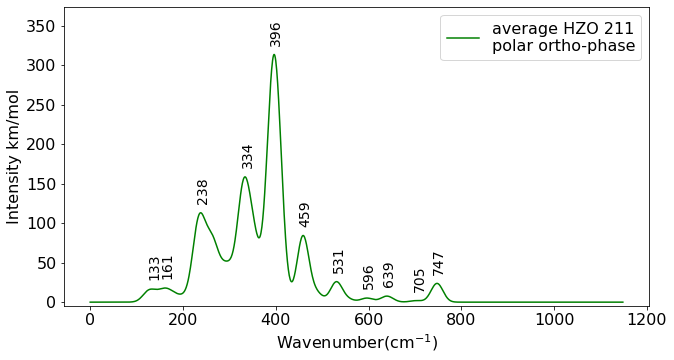

In [51]:
# Calculating the average of all configs
# empty lists to add intensity and frequency values to sum
Int_all = []
wvn_all = []

# iterate over the configs
for k in d_HZO_211_pop_723.keys():
    # adds the frequencies to an empty list
    wvn_all.append(d_HZO_211_pop_723[k]['Frequency'])
    # adds the intensities to an empty list
    Int_all.append(d_HZO_211_pop_723[k]['Raw_abs'])

# total weight of all configurations is 70        
Int_Average_HZO_211 = sum(Int_all)/70
wvn_Average_HZO_211 = sum(wvn_all)/len(wvn_all)

# create figure and axes
fig, ax = plt.subplots()

# white background to appears in dark jupyter theme
rect = fig.patch
rect.set_facecolor('white')

# matplotlib.rcParams.update({'font.size': 18})
# plotting
ax.plot(wvn_Average_HZO_211, Int_Average_HZO_211, c='green', 
         label='average HZO 211\npolar ortho-phase')
ax.legend(fontsize=16)
ax.set_xlabel('Wavenumber(cm$^{-1}$)', fontsize=16)
ax.set_ylabel('Intensity km/mol', fontsize=16)
ax.set_ylim(-5, max(Int_Average_HZO_211)+60)

# adding frequency values to peaks iteratively
for peak in find_peaks(Int_Average_HZO_211)[0]:
    ax.annotate(str(round(wvn_Average_HZO_211[peak])), 
                xytext=(wvn_Average_HZO_211[peak]-10, Int_Average_HZO_211[peak]+15), 
                xy=(wvn_Average_HZO_211[peak], Int_Average_HZO_211[peak]), 
                fontsize=14, rotation=90) 

fig.set_size_inches(10.5, 5.5)
fig.savefig("Average_HZO211_sp29_723.png", bbox_inches="tight")

### Plottting all configurations - normalized using the populations

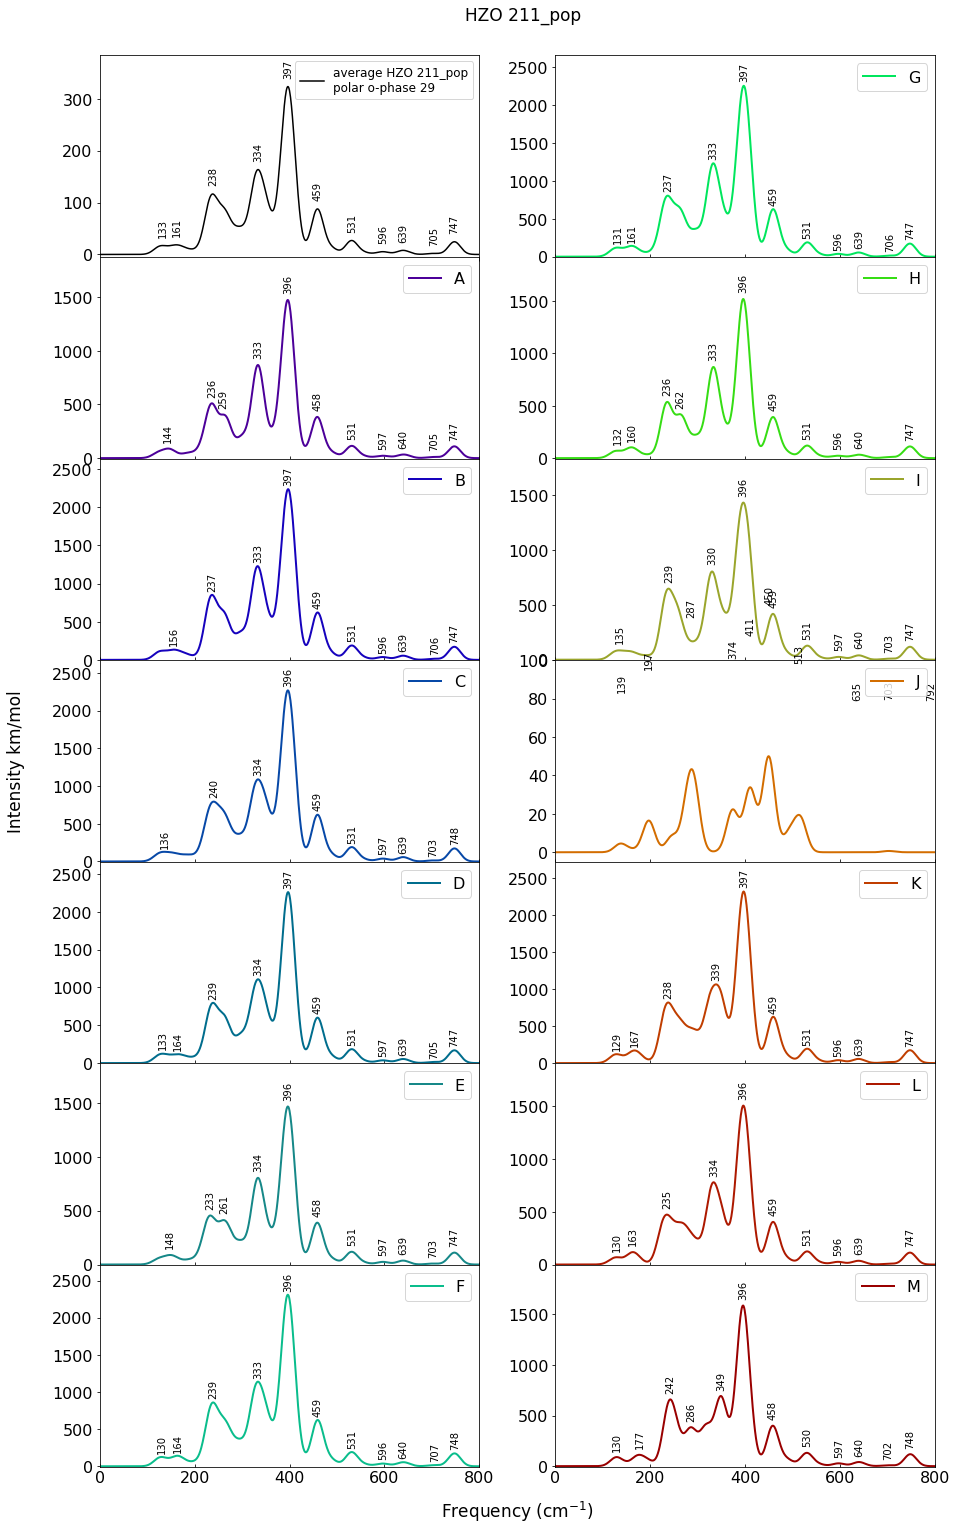

In [134]:
# setting total number of columns and rows
nrows=7
ncols=2
# setting how darker should be the rainbow colors so its more visible
darker=0.6

# creating figure and axes
fig, ax = plt.subplots(nrows, ncols, sharex=True)

# white background to appears in dark jupyter theme
rect = fig.patch
rect.set_facecolor('white')

# creating a range of colors in rainbow style
n = len(d_HZO_211_pop)
colors = cm.rainbow(np.linspace(0, 1, n))

# plot the average on first axis
ax[0,0].plot(wvn_Average_HZO_211[:800], Int_Average_HZO_211[:800], 
             c='black', 
             label='average HZO 211_pop\npolar o-phase 29')
ax[0,0].legend(fontsize=12)
ax[0,0].set_ylim(-5, max(Int_Average_HZO_211)+60)

# annotate the frequency peaks
for peak in find_peaks(Int_Average_HZO_211)[0]:
    ax[0,0].annotate(str(round(wvn_Average_HZO_211[peak])), 
                     xytext=(wvn_Average_HZO_211[peak]-10, Int_Average_HZO_211[peak]+20), 
                     xy=(wvn_Average_HZO_211[peak], Int_Average_HZO_211[peak]), fontsize=10, rotation=90)

for i, j, z in zip(d_HZO_211_pop.keys(), colors, range(len(d_HZO_211_pop))):
    if z < 6:
        rows = z+1
        col = 0
    if  6 <= z < 12:
        rows = z-6
        col = 1
    if z == 12:
        rows = 6
        col = 1
        
    ax[rows,col].plot(d_HZO_211_pop[i].Frequency[:800], d_HZO_211_pop[i].Raw_abs[:800], linewidth=2, 
               label=i, 
               color=adjust_lightness(j, darker))
    ax[rows,col].legend()    
    ax[rows,col].tick_params(axis='x', direction='in')
    ax[rows,col].set_xlim(0, 800)
    if max(d_HZO_211_pop[i].Raw_abs) > 800:
        shift = 400
    else: 
        shift = 50
    ax[rows,col].set_ylim(-5, max(d_HZO_211_pop[i].Raw_abs[:])+shift)
    
        
    # annotate the frequency peaks
    for peak in find_peaks(d_HZO_211_pop[i].Raw_abs[:])[0]:
            #annotation
        ax[rows,col].annotate(str(round(d_HZO_211_pop[i].Frequency[peak])), 
                              xytext=(d_HZO_211_pop[i].Frequency[peak]-10, d_HZO_211_pop[i].Raw_abs[peak]+80), 
                              xy=(d_HZO_211_pop[i].Frequency[peak], d_HZO_211_pop[i].Raw_abs[peak]), 
                              fontsize=10, rotation=90)
        

fig.text(0.45, 0.92, 'HZO 211_pop', fontsize = 17)
fig.text(0.5, 0.075, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.02, 0.5, 'Intensity km/mol', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(14.5, 24.5)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0)

fig.savefig("HZO_211_DFT_IR_population.png", bbox_inches="tight")

### Plottting all configurations - normalized using only the number of atoms in unit cell

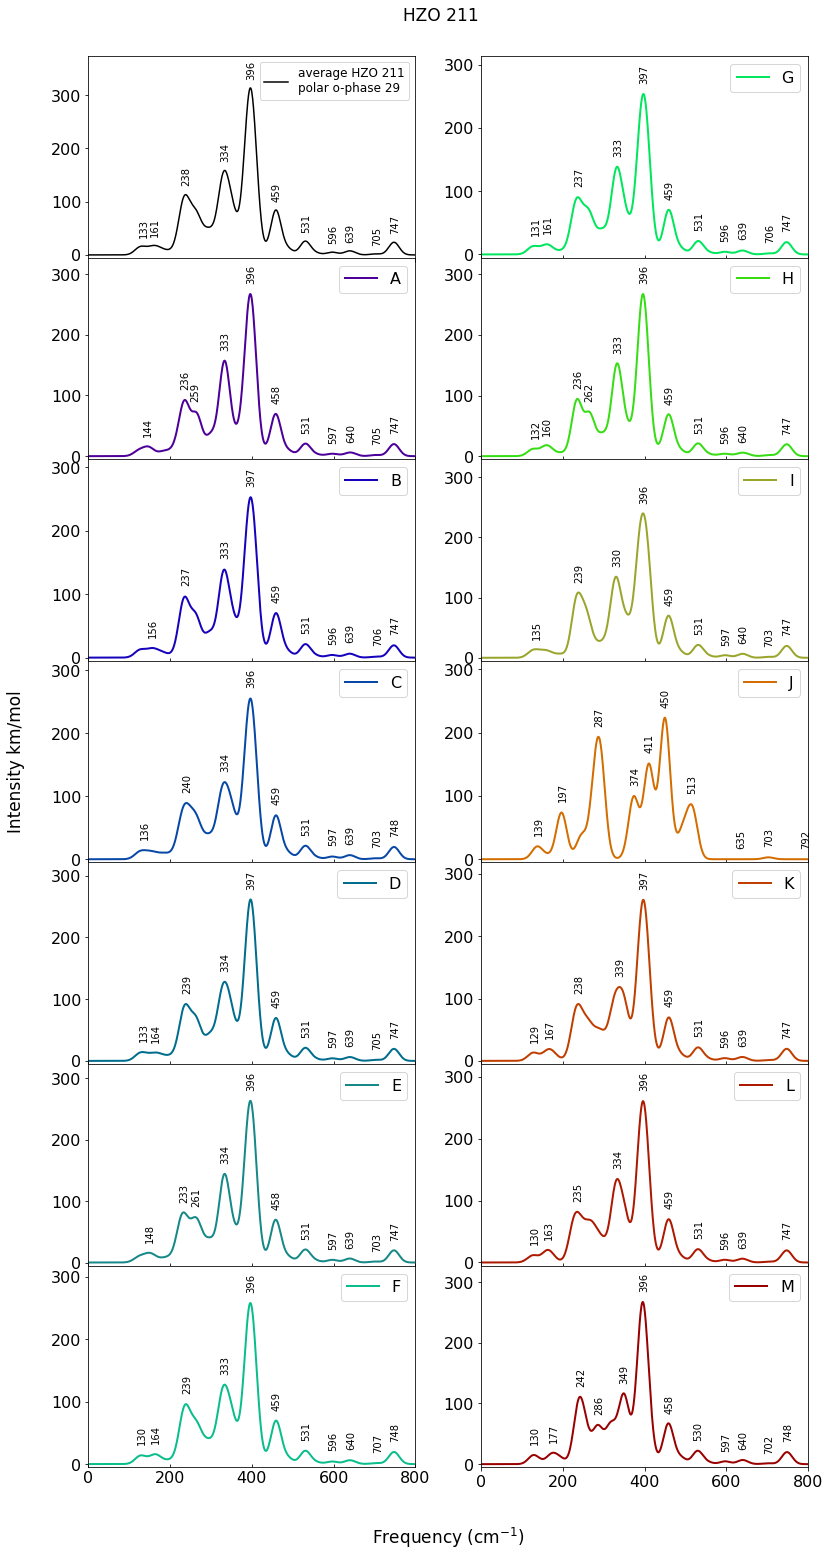

In [53]:
# lists the files to plot
filenames_HZO_211 = glob.glob('HZO_211/*.txt')
# sort them by alphabetical order
filenames_HZO_211.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))


n = len(filenames_HZO_211)


fig, ax = plt.subplots(nrows=7, ncols=2, sharex=True)
rows = 7
columns = 2
grid = plt.GridSpec(rows, columns, wspace = .25, hspace = .25)

# white background to appears in dark jupyter theme
rect = fig.patch
rect.set_facecolor('white')

d_HZO_211 = {}

# colors = colors = ['blue', 'green', 'red', 'magenta', 'orange', 'purple', 'brown', 'black', 'grey']
# colors = colors = ['purple', 'blue', 'green', 'magenta', 'orange', 'red', 'brown', 'black']
colors = cm.rainbow(np.linspace(0, 1, n))

# cmap = get_cmap('tab20c')  # type: matplotlib.colors.ListedColormap
# colors = cmap.colors 
# print(colors)

#how dark the colors should be
darker = 0.6

for i, j, z in zip(filenames_HZO_211, colors, range(len(filenames_HZO_211))):
#     print(z)
    config = pd.read_csv(i, delim_whitespace=True, index_col=False, 
                names=["Frequency", "Wavelength", 
                       "Raw_abs", "Classical_abs", 
                       "Rayleigh_scat1", "Rayleigh_scat2", 
                       "Reflec_x", "Reflec_y", "Reflec_z"], header=None)
    
    d_HZO_211[i[16]] = config[["Frequency", "Raw_abs"]]
    
    non_norm = ["I", "J", "M"]
           
    if z < 6:
#         print('1er ', z)
        if i[16] in non_norm:
            ax[z+1,0].plot(config.Frequency[:800], config.Raw_abs[:800]*2, linewidth=2, 
                   label=i[16], 
                   color=adjust_lightness(j, darker))
        else:
            ax[z+1,0].plot(config.Frequency[:800], config.Raw_abs[:800], linewidth=2, 
                   label=i[16], 
                   color=adjust_lightness(j, darker))
        ax[z+1,0].legend()    
        ax[z+1,0].tick_params(axis='x', direction='in')
        ax[z+1,0].set_ylim(-5, max(config.Raw_abs[:])+60)
        ax[z+1,0].set_xlim(0, 800)
        
#         print(find_peaks(config.Raw_abs[:])[0])
        for peak in find_peaks(config.Raw_abs[:])[0]:
#             print(peak)
        
            #annotation
            ax[z+1,0].annotate(str(round(config.Frequency[peak])), xytext=(config.Frequency[peak]-10, config.Raw_abs[peak]+20), 
                             xy=(config.Frequency[peak], config.Raw_abs[peak]), fontsize=10, rotation=90)
        
    if  6 <= z < 12:
        if i[16] in non_norm:
            normalized = config.Raw_abs[:800]*2
            ax[z-6, 1].plot(config.Frequency[:800], normalized, linewidth=2, 
                   label=i[16], 
                   color=adjust_lightness(j, darker))
            ax[z-6, 1].set_ylim(-5, max(normalized)+90)
            
            for peak in find_peaks(normalized[:])[0]:
                ax[z-6, 1].annotate(str(round(config.Frequency[peak])), xytext=(config.Frequency[peak]-10, normalized[peak]+20), 
                             xy=(config.Frequency[peak], normalized[peak]), fontsize=10, rotation=90)
            
        else:    
            ax[z-6, 1].plot(config.Frequency[:800], config.Raw_abs[:800], linewidth=2, 
                   label=i[16], 
                   color=adjust_lightness(j, darker))
            ax[z-6, 1].set_ylim(-5, max(config.Raw_abs[:])+60)
            for peak in find_peaks(config.Raw_abs[:])[0]:
                ax[z-6, 1].annotate(str(round(config.Frequency[peak])), xytext=(config.Frequency[peak]-10, config.Raw_abs[peak]+20), 
                             xy=(config.Frequency[peak], config.Raw_abs[peak]), fontsize=10, rotation=90)
        
        ax[z-6, 1].legend()  
        ax[z-6, 1].tick_params(axis='x', direction='in')
        
        
        
        
    if z == 12:
        if i[16] in non_norm: 
            normalized = config.Raw_abs[:800]*2
            ax[6,1].plot(config.Frequency[:800], normalized, linewidth=2, 
                   label=i[16], 
                   color=adjust_lightness(j, darker))
            ax[6,1].legend()
            ax[6,1].set_ylim(-5, max(normalized)+60)
            for peak in find_peaks(normalized)[0]:
                ax[6,1].annotate(str(round(config.Frequency[peak])), xytext=(config.Frequency[peak]-10, normalized[peak]+20), 
                             xy=(config.Frequency[peak], normalized[peak]), fontsize=10, rotation=90)        
        else:
            continue
        
ax[0,0].plot(wvn_Average_HZO_211[:800], Int_Average_HZO_211[:800], c='black', 
         label='average HZO 211\npolar o-phase 29')
ax[0,0].legend(fontsize=12)
ax[0,0].set_ylim(-5, max(Int_Average_HZO_211)+60)

for peak in find_peaks(Int_Average_HZO_211)[0]:
    ax[0,0].annotate(str(round(wvn_Average_HZO_211[peak])), xytext=(wvn_Average_HZO_211[peak]-10, Int_Average_HZO_211[peak]+20), 
                     xy=(config.Frequency[peak], config.Raw_abs[peak]), fontsize=10, rotation=90)  
    
    
# sub2 = fig.add_subplot(grid[6, :])   
# plt.annotate('sub2', xy = (0.5, 0.5), va = 'center', ha = 'center',  weight='bold', fontsize = 15)

fig.text(0.45, 0.92, 'HZO 211', fontsize = 17)
fig.text(0.5, 0.06, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.02, 0.5, 'Intensity km/mol', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(12.5, 24.5)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0)


fig.savefig("HZO_211_DFT_IR_atoms_unit_cell.png", bbox_inches="tight")

## HZO 112 DFT

### Calculating and plotting the average

Degeneracies of HZO supercell 1x1x2 : 

A - 4, J - 4 

B - 8, C - 8, D - 8, E - 8, F - 8, G - 8, I - 8,

H - 2, K - 2, L - 2


In [135]:
df_HZO_112_populations = pd.read_csv("energies_population_HZO_112.csv")
df_HZO_112_populations

,Unnamed: 0,normalized_population,normalized_population %
0,HZO_112_A,0.038035,3.803481
1,HZO_112_B,0.039932,3.993206
2,HZO_112_C,0.041413,4.141315
3,HZO_112_D,0.041463,4.146311
4,HZO_112_E,0.040579,4.057914
5,HZO_112_F,0.041739,4.173892
6,HZO_112_G,0.041272,4.127222
7,HZO_112_H,0.013914,1.391406
8,HZO_112_I,0.042677,4.267696
9,HZO_112_J,0.631268,63.126805


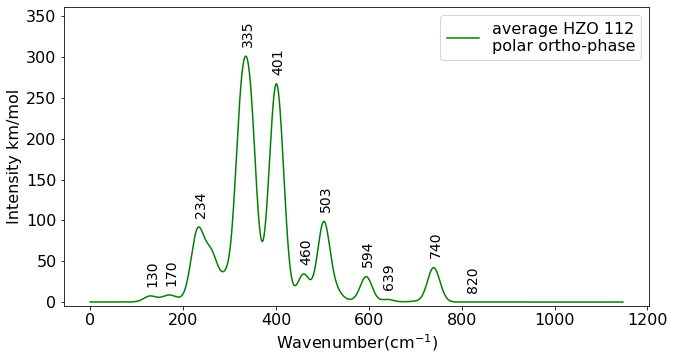

In [136]:
# opening populations coming from another notebook 
df_HZO_112_populations = pd.read_csv("energies_population_HZO_112.csv")

# listing all files to plot
filenames_HZO_112 = glob.glob('HZO_112/*.txt')
# sort them by alphabetical order
filenames_HZO_112.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

# # white background to appears in dark jupyter theme
# fig, ax = plt.subplots(nrows=len(filenames_HZO_112), ncols=1, figsize=(6,35))
# rect = fig.patch
# rect.set_facecolor('white')

# empty dictionary to add the normalized data
d_HZO_112_pop = {}

# iterate over the list of files to plot and the population of each config to be multiplied
for i, population in zip(filenames_HZO_112, df_HZO_112_populations["normalized_population %"]):
#     print(i, population)
    # opens the spectrm file of one config
    config = pd.read_csv(i, delim_whitespace=True, index_col=False, 
                names=["Frequency", "Wavelength", 
                       "Raw_abs", "Classical_abs", 
                       "Rayleigh_scat1", "Rayleigh_scat2", 
                       "Reflec_x", "Reflec_y", "Reflec_z"], header=None)
    # calculates the weight of this config
    config["Raw_abs"] = config.Raw_abs*population
    # saves this config inside the dict
    d_HZO_112_pop[i[16]] = config[["Frequency", "Raw_abs"]]
    
# Calculating the average of all configs
# empty lists to add intensity and frequency values to sum
Int_all = []
wvn_all = []

# iterate over the configs
for k in d_HZO_112_pop.keys():
    # adds the frequencies to an empty list
    wvn_all.append(d_HZO_112_pop[k]['Frequency'])
    # adds the intensities to an empty list
    Int_all.append(d_HZO_112_pop[k]['Raw_abs'])

# total weight of all configurations is 70        
Int_Average_HZO_112 = sum(Int_all)/70
wvn_Average_HZO_112 = sum(wvn_all)/len(wvn_all)

# create figure and axes
fig, ax = plt.subplots()

# white background to appears in dark jupyter theme
rect = fig.patch
rect.set_facecolor('white')

# matplotlib.rcParams.update({'font.size': 18})
# plotting
ax.plot(wvn_Average_HZO_112, Int_Average_HZO_112, c='green', 
         label='average HZO 112\npolar ortho-phase')
ax.legend(fontsize=16)
ax.set_xlabel('Wavenumber(cm$^{-1}$)', fontsize=16)
ax.set_ylabel('Intensity km/mol', fontsize=16)
ax.set_ylim(-5, max(Int_Average_HZO_112)+60)

# adding frequency values to peaks iteratively
for peak in find_peaks(Int_Average_HZO_112)[0]:
    ax.annotate(str(round(wvn_Average_HZO_112[peak])), 
                xytext=(wvn_Average_HZO_112[peak]-10, Int_Average_HZO_112[peak]+15), 
                xy=(wvn_Average_HZO_112[peak], Int_Average_HZO_112[peak]), 
                fontsize=14, rotation=90) 

fig.set_size_inches(10.5, 5.5)
fig.savefig("Average_HZO112_sp29.png", bbox_inches="tight")    

### Plottting all configurations - normalized using the populations

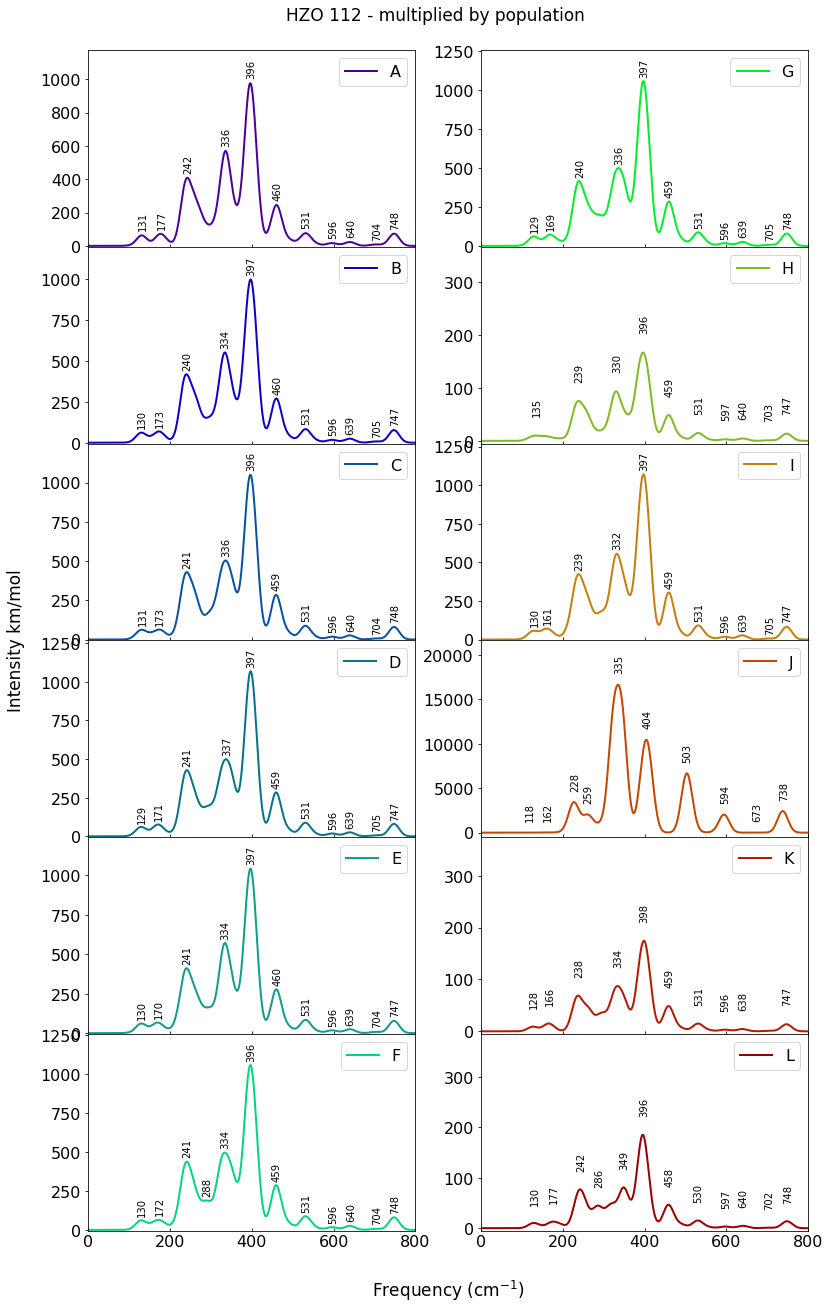

In [137]:
nrows=6
ncols=2
darker=0.6

# creating figure and axes
fig, ax = plt.subplots(nrows, ncols, sharex=True)

# white background to appears in dark jupyter theme
rect = fig.patch
rect.set_facecolor('white')

# creating a range of colors in rainbow style
n = len(d_HZO_112_pop)
colors = cm.rainbow(np.linspace(0, 1, n))

# itarating over the files, colors and columns fot he figure
for i, j, z in zip(d_HZO_112_pop.keys(), colors, range(len(d_HZO_112_pop))):
    # plotting half of data into the first column of figure and half into the second column
    if z < nrows:
        rows = z
        col = 0
    else:
        rows = z-nrows
        col = 1
        
    ax[rows,col].plot(d_HZO_112_pop[i].Frequency[:800], d_HZO_112_pop[i].Raw_abs[:800], linewidth=2, 
               label=i, 
               color=adjust_lightness(j, darker))
    ax[rows,col].legend()  
    ax[rows,col].tick_params(axis='x', direction='in')

    if max(d_HZO_112_pop[i].Raw_abs[:]) > 2000:
        ax[rows,col].set_ylim(-500, max(d_HZO_112_pop[i].Raw_abs[:])+5000)
    if max(d_HZO_112_pop[i].Raw_abs[:]) < 2000:
        ax[rows,col].set_ylim(-5, max(d_HZO_112_pop[i].Raw_abs[:])+200)

    ax[rows,col].set_xlim(0, 800)
    # adding the frequency values to the peaks
    for peak in find_peaks(d_HZO_112_pop[i].Raw_abs[:])[0]:
        # annotation of the peak frequencies
        if max(d_HZO_112_pop[i].Raw_abs[:]) > 2000:
            shift = 1500
        if max(d_HZO_112_pop[i].Raw_abs[:]) < 2000:
            shift = 40    
        ax[rows,col].annotate(str(round(d_HZO_112_pop[i].Frequency[peak])), 
                         xytext=(d_HZO_112_pop[i].Frequency[peak]-10, d_HZO_112_pop[i].Raw_abs[peak]+shift), 
                         xy=(d_HZO_112_pop[i].Frequency[peak], d_HZO_112_pop[i].Raw_abs[peak]), 
                         fontsize=10, rotation=90)
        

fig.text(0.32, 0.92, "HZO 112 - multiplied by population", fontsize = 17)
fig.text(0.5, 0.06, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.02, 0.5, 'Intensity km/mol', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(12.5, 20.5)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0)


fig.savefig("HZO_112_DFT_IR_populations.png", bbox_inches="tight")

### Plottting all configurations - normalized using only the number of atoms in unit cell

In [57]:
filenames_HZO_112 = glob.glob('HZO_112/*.txt')
filenames_HZO_112.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

# # white background to appears in dark jupyter theme
# fig, ax = plt.subplots(nrows=len(filenames_HZO_112), ncols=1, figsize=(6,35))
# rect = fig.patch
# rect.set_facecolor('white')

# empty dictionary to add the normalized data
d_HZO_112 = {}

# the list of non normalized configurations
non_norm = ["H", "K", "L"]

for i in filenames_HZO_112:
#     print(z)
    config = pd.read_csv(i, delim_whitespace=True, index_col=False, 
                names=["Frequency", "Wavelength", 
                       "Raw_abs", "Classical_abs", 
                       "Rayleigh_scat1", "Rayleigh_scat2", 
                       "Reflec_x", "Reflec_y", "Reflec_z"], header=None)
    if i[16] in non_norm:
        config["Raw_abs"] = config.Raw_abs*2
        d_HZO_112[i[16]] = config[["Frequency", "Raw_abs"]]
    else:
        d_HZO_112[i[16]] = config[["Frequency", "Raw_abs"]]
        
# for k, nrow in zip(d_HZO_112.keys(), range(len(filenames_HZO_112))):
#     ax[nrow].plot(d_HZO_112[k]["Frequency"], d_HZO_112[k]["Raw_abs"], label = k)
#     ax[nrow].legend()

In [58]:
d_HZO_112

{'A':       Frequency       Raw_abs
 0         0.001  3.367130e-14
 1         1.001  6.138660e-14
 2         2.001  1.112300e-13
 3         3.001  2.003100e-13
 4         4.001  3.585250e-13
 ...         ...           ...
 1144   1144.000  0.000000e+00
 1145   1145.000  0.000000e+00
 1146   1146.000  0.000000e+00
 1147   1147.000  0.000000e+00
 1148   1148.000  0.000000e+00
 
 [1149 rows x 2 columns],
 'B':       Frequency       Raw_abs
 0         0.001  1.248590e-14
 1         1.001  2.283250e-14
 2         2.001  4.150040e-14
 3         3.001  7.497500e-14
 4         4.001  1.346310e-13
 ...         ...           ...
 1144   1144.000  0.000000e+00
 1145   1145.000  0.000000e+00
 1146   1146.000  0.000000e+00
 1147   1147.000  0.000000e+00
 1148   1148.000  0.000000e+00
 
 [1149 rows x 2 columns],
 'C':       Frequency       Raw_abs
 0         0.001  2.543390e-13
 1         1.001  4.487230e-13
 2         2.001  7.868180e-13
 3         3.001  1.371200e-12
 4         4.001  2.374960e-12

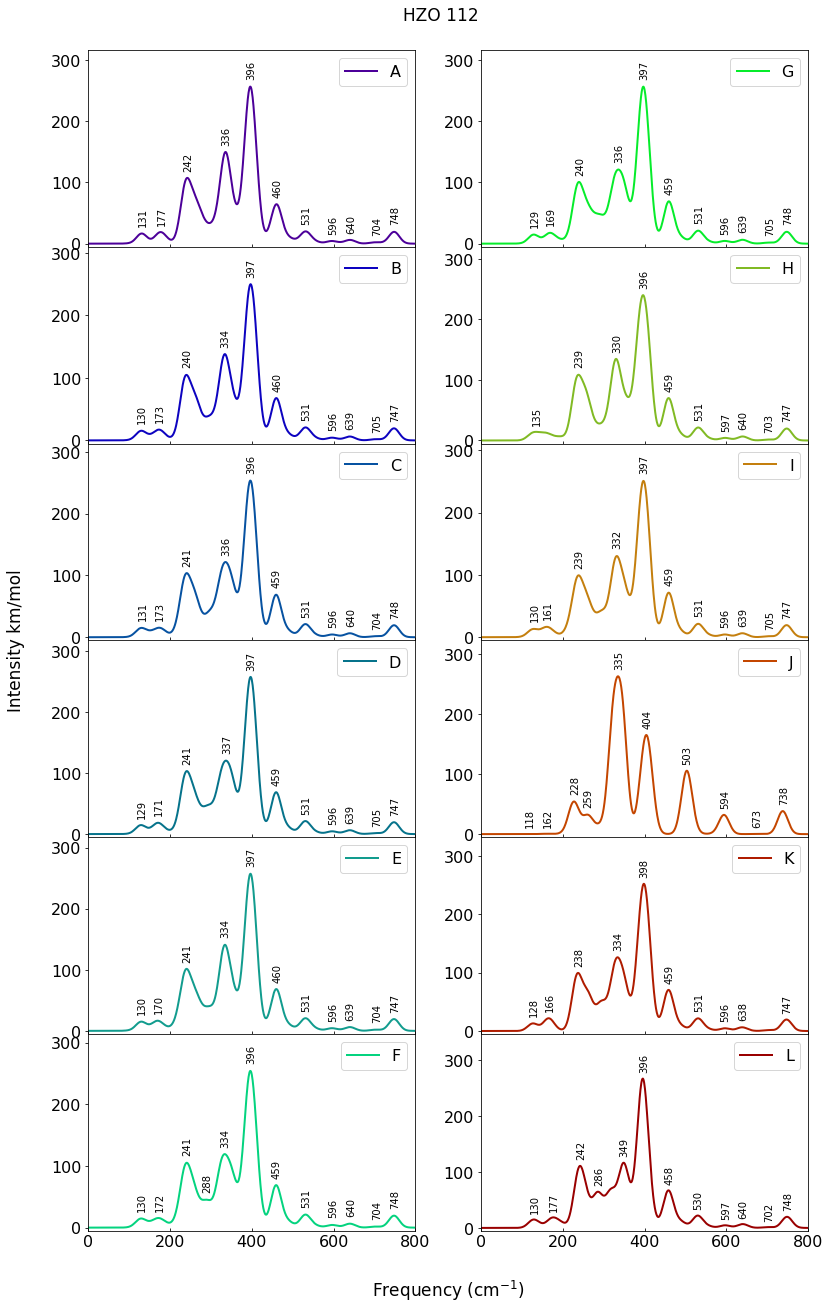

In [59]:
# reading the files from folder
filenames_HZO_112 = glob.glob('HZO_112/*.txt')
# putting the files in order
filenames_HZO_112.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

# creating figure and axes
fig, ax = plt.subplots(nrows=6, ncols=2, sharex=True)

# white background to appears in dark jupyter theme
rect = fig.patch
rect.set_facecolor('white')

# creating a range of colors in rainbow style
n = len(filenames_HZO_112)
colors = cm.rainbow(np.linspace(0, 1, n))

# itarating over the files, colors and columns fot he figure
for i, j, z in zip(filenames_HZO_112, colors, range(len(filenames_HZO_112))):
    #opening the files with pandas
    config = pd.read_csv(i, delim_whitespace=True, index_col=False, 
                names=["Frequency", "Wavelength", 
                       "Raw_abs", "Classical_abs", 
                       "Rayleigh_scat1", "Rayleigh_scat2", 
                       "Reflec_x", "Reflec_y", "Reflec_z"], header=None)
    
    non_norm = ["H", "K", "L"]
    
    # plotting half of data into the first column of figure
    if z < 6:
            ax[z,0].plot(config.Frequency[:800], config.Raw_abs[:800], linewidth=2, 
                       label=i[16], 
                       color=adjust_lightness(j, darker))
            ax[z,0].legend()  
            ax[z,0].tick_params(axis='x', direction='in')
            ax[z,0].set_ylim(-5, max(config.Raw_abs[:])+60)
            ax[z,0].set_xlim(0, 800)
            # adding the frequency values to the peaks
            for peak in find_peaks(config.Raw_abs[:])[0]:
    #             print(peak)

                #annotation
                ax[z,0].annotate(str(round(config.Frequency[peak])), xytext=(config.Frequency[peak]-10, config.Raw_abs[peak]+15), 
                                 xy=(config.Frequency[peak], config.Raw_abs[peak]), fontsize=10, rotation=90)

    else:
        if i[16] in non_norm:
            normalized = config.Raw_abs[:800]*2
            ax[z-6, 1].plot(config.Frequency[:800], normalized, linewidth=2, 
                            label=i[16], 
                            color=adjust_lightness(j, darker))
            ax[z-6, 1].set_ylim(-5, max(normalized)+80)
            for peak in find_peaks(normalized)[0]:
                ax[z-6, 1].annotate(str(round(config.Frequency[peak])), xytext=(config.Frequency[peak]-10, normalized[peak]+15), 
                                 xy=(config.Frequency[peak], normalized[peak]), fontsize=10, rotation=90)
            
        else:   
            ax[z-6, 1].plot(config.Frequency[:800], config.Raw_abs[:800], linewidth=2, 
                            label=i[16], 
                            color=adjust_lightness(j, darker))
            
            ax[z-6, 1].set_ylim(-5, max(config.Raw_abs[:])+60)
            for peak in find_peaks(config.Raw_abs[:])[0]:
                ax[z-6, 1].annotate(str(round(config.Frequency[peak])), xytext=(config.Frequency[peak]-10, config.Raw_abs[peak]+15), 
                                 xy=(config.Frequency[peak], config.Raw_abs[peak]), fontsize=10, rotation=90)
        ax[z-6, 1].legend() 
        ax[z-6, 1].tick_params(axis='x', direction='in')
    
fig.text(0.45, 0.92, 'HZO 112', fontsize = 17)
fig.text(0.5, 0.06, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.02, 0.5, 'Intensity km/mol', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(12.5, 20.5)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0)


fig.savefig("HZO_DFT_112_IR_atoms_unit_cell.png", bbox_inches="tight")

## Plotting the 3 averages HZO 112, 121, 211 together

### Using Boltzmann distribution for each direction 112, 121, 211 separated

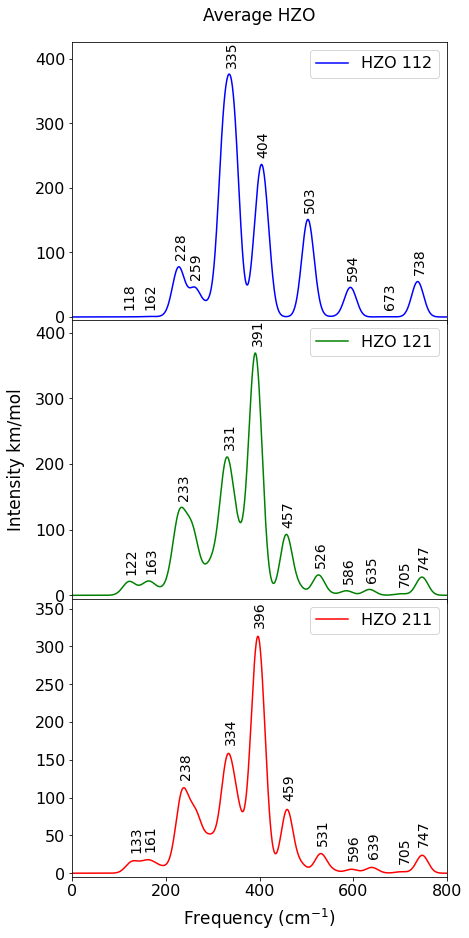

In [60]:
# creating figure and axes
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

# white background to appears in dark jupyter theme
rect = fig.patch
rect.set_facecolor('white')

# creating a range of colors in rainbow style
colors = cm.rainbow(np.linspace(0, 1, 3))

# itarating over the files, colors and columns fot he figure

ax[0].plot(wvn_Average_HZO_112, Int_Average_HZO_112, c='blue', 
     label='HZO 112')
ax[0].legend(fontsize=16)
ax[0].set_ylim(-5, max(Int_Average_HZO_112)+50)
ax[0].set_xlim(0, 800)

for peak in find_peaks(Int_Average_HZO_112)[0]:
    ax[0].annotate(str(round(wvn_Average_HZO_112[peak])), xytext=(wvn_Average_HZO_112[peak]-10, Int_Average_HZO_112[peak]+15), 
                     xy=(wvn_Average_HZO_112[peak], Int_Average_HZO_112[peak]), fontsize=14, rotation=90) 
            

ax[1].plot(wvn_Average_HZO_121, Int_Average_HZO_121, c='green', 
     label='HZO 121')
ax[1].legend(fontsize=16)
ax[1].set_ylim(-5, max(Int_Average_HZO_121)+50)

for peak in find_peaks(Int_Average_HZO_121)[0]:
    ax[1].annotate(str(round(wvn_Average_HZO_121[peak])), xytext=(wvn_Average_HZO_121[peak]-10, Int_Average_HZO_121[peak]+15), 
                     xy=(wvn_Average_HZO_121[peak], Int_Average_HZO_112[peak]), fontsize=14, rotation=90) 

ax[2].plot(wvn_Average_HZO_211, Int_Average_HZO_211, c='red', 
     label='HZO 211')
ax[2].legend(fontsize=16)
ax[2].set_ylim(-5, max(Int_Average_HZO_211)+50)

for peak in find_peaks(Int_Average_HZO_211)[0]:
    ax[2].annotate(str(round(wvn_Average_HZO_211[peak])), xytext=(wvn_Average_HZO_211[peak]-10, Int_Average_HZO_211[peak]+15), 
                     xy=(wvn_Average_HZO_211[peak], Int_Average_HZO_211[peak]), fontsize=14, rotation=90) 

    
fig.text(0.38, 0.92, 'Average HZO', fontsize = 17)
fig.text(0.5, 0.06, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(-0.02, 0.5, 'Intensity km/mol', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(6.5, 14.5)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0)


fig.savefig("Average_HZO_vertical.png", bbox_inches="tight")

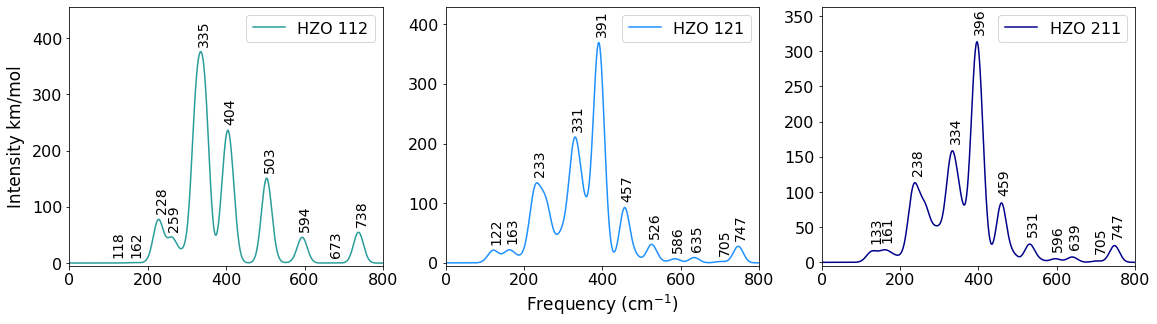

In [106]:
# creating figure and axes
fig, ax = plt.subplots(nrows=1, ncols=3) #, sharey=True)

# white background to appears in dark jupyter theme
rect = fig.patch
rect.set_facecolor('white')

# creating a range of colors in rainbow style
colors = cm.rainbow(np.linspace(0, 1, 3))

# itarating over the files, colors and columns fot he figure

ax[0].plot(wvn_Average_HZO_112, Int_Average_HZO_112, c=adjust_lightness('mediumturquoise', amount=0.7), 
     label='HZO 112')
ax[0].legend(fontsize=16)
ax[0].set_ylim(-5, max(Int_Average_HZO_112)+80)
ax[0].set_xlim(0, 800)

for peak in find_peaks(Int_Average_HZO_112)[0]:
    ax[0].annotate(str(round(wvn_Average_HZO_112[peak])), xytext=(wvn_Average_HZO_112[peak]-10, Int_Average_HZO_112[peak]+15), 
                     xy=(wvn_Average_HZO_112[peak], Int_Average_HZO_112[peak]), fontsize=14, rotation=90) 
            

ax[1].plot(wvn_Average_HZO_121, Int_Average_HZO_121, c='dodgerblue', 
     label='HZO 121')
ax[1].legend(fontsize=16)
ax[1].set_ylim(-5, max(Int_Average_HZO_121)+60)
ax[1].set_xlim(0, 800)

for peak in find_peaks(Int_Average_HZO_121)[0]:
    ax[1].annotate(str(round(wvn_Average_HZO_121[peak])), xytext=(wvn_Average_HZO_121[peak]-10, Int_Average_HZO_121[peak]+15), 
                     xy=(wvn_Average_HZO_121[peak], Int_Average_HZO_112[peak]), fontsize=14, rotation=90) 

ax[2].plot(wvn_Average_HZO_211, Int_Average_HZO_211, c='darkblue', 
     label='HZO 211')
ax[2].legend(fontsize=16)
ax[2].set_ylim(-5, max(Int_Average_HZO_211)+50)
ax[2].set_xlim(0, 800)
for peak in find_peaks(Int_Average_HZO_211)[0]:
    ax[2].annotate(str(round(wvn_Average_HZO_211[peak])), xytext=(wvn_Average_HZO_211[peak]-10, Int_Average_HZO_211[peak]+15), 
                     xy=(wvn_Average_HZO_211[peak], Int_Average_HZO_211[peak]), fontsize=14, rotation=90) 

    
# fig.text(0.38, 0.92, 'Average HZO', fontsize = 17)
fig.text(0.5, -0.02, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.06, 0.5, 'Intensity km/mol', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(18.5, 4.5)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0)


fig.savefig("Average_HZO_SC.png", bbox_inches="tight")

### Using only 1 Boltzmann distribution for all HZO 112, 121, 211 together

In [147]:
# opening populations coming from another notebook 
df_HZO_all_populations = pd.read_csv("population_HZO_all.csv")
df_HZO_all_populations = df_HZO_all_populations.sort_values('Unnamed: 0')
df_HZO_all_populations

,Unnamed: 0,normalized_population,normalized_population %
27,HZO_112_A,0.01513,1.51298
28,HZO_112_B,0.03177,3.17690
29,HZO_112_C,0.03295,3.29473
30,HZO_112_D,0.03299,3.29870
31,HZO_112_E,0.03228,3.22837
32,HZO_112_F,0.03321,3.32064
33,HZO_112_G,0.03284,3.28352
34,HZO_112_H,0.04428,4.42787
35,HZO_112_I,0.03395,3.39527
36,HZO_112_J,0.25111,25.11106


In [148]:
# listing all files to plot
filenames_HZO_all = glob.glob('HZO_all/*.txt')
# sort them by alphabetical order
filenames_HZO_all.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

# # white background to appears in dark jupyter theme
# fig, ax = plt.subplots(nrows=len(filenames_HZO_all), ncols=1, figsize=(6,35))
# rect = fig.patch
# rect.set_facecolor('white')

# empty dictionary to add the normalized data
d_HZO_all_pop = {}

# iterate over the list of files to plot and the population of each config to be multiplied
for i, population in zip(filenames_HZO_all, df_HZO_all_populations["normalized_population %"]):
    print(i[8:17], population)
    # opens the spectrm file of one config
    config = pd.read_csv(i, delim_whitespace=True, index_col=False, 
                names=["Frequency", "Wavelength", 
                       "Raw_abs", "Classical_abs", 
                       "Rayleigh_scat1", "Rayleigh_scat2", 
                       "Reflec_x", "Reflec_y", "Reflec_z"], header=None)
    # calculates the weight of this config
    config["Raw_abs"] = config.Raw_abs*population
    # saves this config inside the dict
    d_HZO_all_pop[i[16]] = config[["Frequency", "Raw_abs"]]

HZO_112_A 1.51298
HZO_112_B 3.1769
HZO_112_C 3.29473
HZO_112_D 3.2987
HZO_112_E 3.22837
HZO_112_F 3.32064
HZO_112_G 3.28352
HZO_112_H 4.42787
HZO_112_I 3.39527
HZO_112_J 25.11106
HZO_112_K 4.40731
HZO_112_L 4.41005
HZO_121_A 0.0
HZO_121_B 0.0
HZO_121_C 0.0
HZO_121_D 0.0
HZO_121_E 0.0
HZO_121_F 0.0
HZO_121_G 0.0
HZO_121_H 0.0
HZO_121_I 0.0
HZO_121_J 0.0
HZO_121_K 0.0
HZO_121_L 0.0
HZO_121_M 0.0
HZO_121_N 0.0
HZO_211_A 2.0488
HZO_211_B 3.28564
HZO_211_C 3.30117
HZO_211_D 3.21155
HZO_211_E 2.07182
HZO_211_F 3.32605
HZO_211_G 3.30037
HZO_211_H 2.1094
HZO_211_I 4.42784
HZO_211_J 0.16614
HZO_211_K 3.32472
HZO_211_L 2.14906
HZO_211_M 4.41004


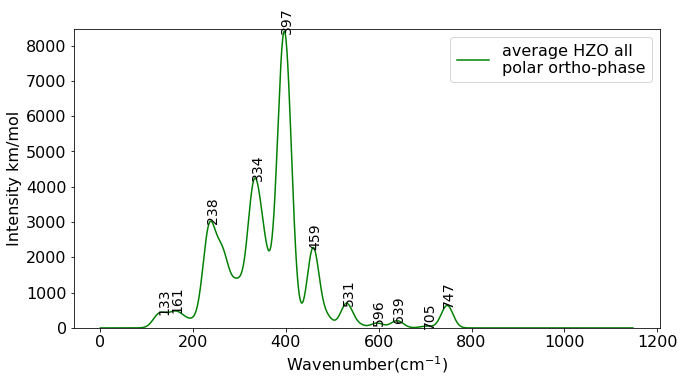

In [151]:
# Calculating the average of all configs
# empty lists to add intensity and frequency values to sum
Int_all = []
wvn_all = []

# iterate over the configs
for k in d_HZO_all_pop.keys():
    # adds the frequencies to an empty list
    wvn_all.append(d_HZO_all_pop[k]['Frequency'])
    # adds the intensities to an empty list
    Int_all.append(d_HZO_all_pop[k]['Raw_abs'])

# total weight of all configurations is 70        
Int_Average_HZO_all = sum(Int_all) #/210
wvn_Average_HZO_all = sum(wvn_all)/len(wvn_all)

# create figure and axes
fig, ax = plt.subplots()

# white background to appears in dark jupyter theme
rect = fig.patch
rect.set_facecolor('white')

# matplotlib.rcParams.update({'font.size': 18})
# plotting
ax.plot(wvn_Average_HZO_all, Int_Average_HZO_all, c='green', 
         label='average HZO all\npolar ortho-phase')
ax.legend(fontsize=16)
ax.set_xlabel('Wavenumber(cm$^{-1}$)', fontsize=16)
ax.set_ylabel('Intensity km/mol', fontsize=16)
ax.set_ylim(-5, max(Int_Average_HZO_all)+60)

# adding frequency values to peaks iteratively
for peak in find_peaks(Int_Average_HZO_all)[0]:
    ax.annotate(str(round(wvn_Average_HZO_all[peak])), 
                xytext=(wvn_Average_HZO_all[peak]-10, Int_Average_HZO_all[peak]+15), 
                xy=(wvn_Average_HZO_all[peak], Int_Average_HZO_all[peak]), 
                fontsize=14, rotation=90) 

fig.set_size_inches(10.5, 5.5)
# fig.savefig("Average_HZOall_sp29.png", bbox_inches="tight")

## ATAT DFT Results

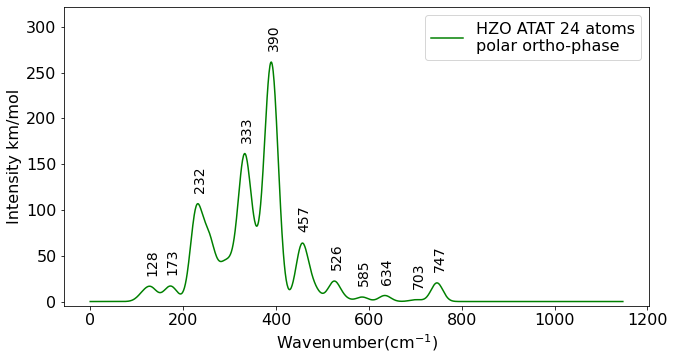

In [64]:
HZO_ortho_24atoms = pd.read_csv("ATAT_DFT/distance_12/atat_HZO_SC_ortho29_24atoms.txt",
                     delim_whitespace=True, index_col=False, 
                names=["Frequency", "Wavelength", 
                       "Raw_abs", "Classical_abs", 
                       "Rayleigh_scat1", "Rayleigh_scat2", 
                       "Reflec_x", "Reflec_y", "Reflec_z"], header=None)

# create figure and axes
fig, ax = plt.subplots()

# white background to appears in dark jupyter theme
rect = fig.patch
rect.set_facecolor('white')

# matplotlib.rcParams.update({'font.size': 18})
# plotting
ax.plot(HZO_ortho_24atoms.Frequency, HZO_ortho_24atoms.Raw_abs, c='green', 
         label='HZO ATAT 24 atoms\npolar ortho-phase')
ax.legend(fontsize=16)
ax.set_xlabel('Wavenumber(cm$^{-1}$)', fontsize=16)
ax.set_ylabel('Intensity km/mol', fontsize=16)
ax.set_ylim(-5, max(HZO_ortho_24atoms.Raw_abs)+60)

# adding frequency values to peaks iteratively
for peak in find_peaks(HZO_ortho_24atoms.Raw_abs)[0]:
    ax.annotate(str(round(HZO_ortho_24atoms.Frequency[peak])), 
                xytext=(HZO_ortho_24atoms.Frequency[peak]-10, HZO_ortho_24atoms.Raw_abs[peak]+15), 
                xy=(HZO_ortho_24atoms.Frequency[peak], HZO_ortho_24atoms.Raw_abs[peak]), 
                fontsize=14, rotation=90) 

fig.set_size_inches(10.5, 5.5)

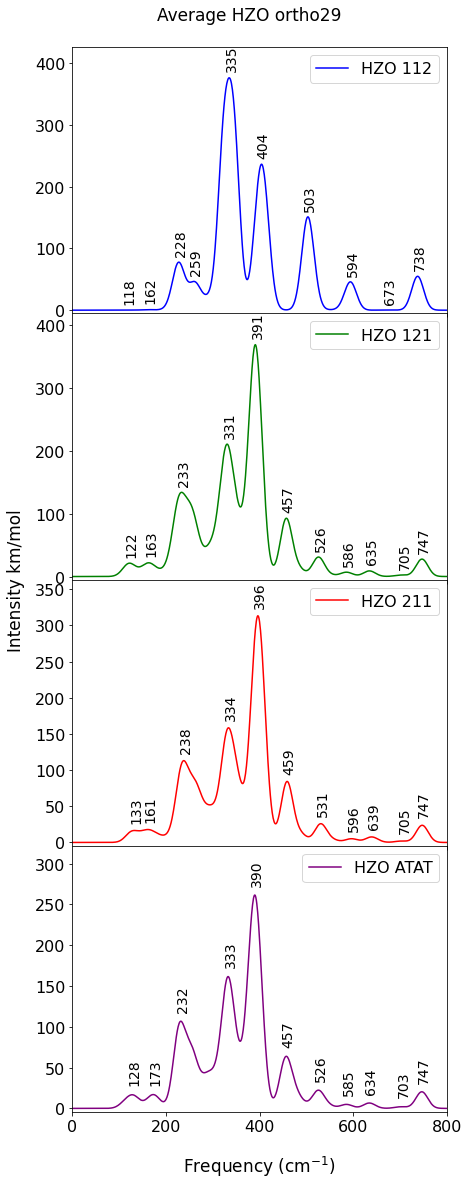

In [75]:
# creating figure and axes
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True)

# white background to appears in dark jupyter theme
rect = fig.patch
rect.set_facecolor('white')

# itarating over the files, colors and columns fot he figure

ax[0].plot(wvn_Average_HZO_112, Int_Average_HZO_112, c='blue', 
     label='HZO 112')
ax[0].legend(fontsize=16)
ax[0].set_ylim(-5, max(Int_Average_HZO_112)+50)
ax[0].set_xlim(0, 800)

for peak in find_peaks(Int_Average_HZO_112)[0]:
    ax[0].annotate(str(round(wvn_Average_HZO_112[peak])), xytext=(wvn_Average_HZO_112[peak]-10, Int_Average_HZO_112[peak]+15), 
                     xy=(wvn_Average_HZO_112[peak], Int_Average_HZO_112[peak]), fontsize=14, rotation=90) 
            

ax[1].plot(wvn_Average_HZO_121, Int_Average_HZO_121, c='green', 
     label='HZO 121')
ax[1].legend(fontsize=16)
ax[1].set_ylim(-5, max(Int_Average_HZO_121)+50)

for peak in find_peaks(Int_Average_HZO_121)[0]:
    ax[1].annotate(str(round(wvn_Average_HZO_121[peak])), xytext=(wvn_Average_HZO_121[peak]-10, Int_Average_HZO_121[peak]+15), 
                     xy=(wvn_Average_HZO_121[peak], Int_Average_HZO_112[peak]), fontsize=14, rotation=90) 

ax[2].plot(wvn_Average_HZO_211, Int_Average_HZO_211, c='red', 
     label='HZO 211')
ax[2].legend(fontsize=16)
ax[2].set_ylim(-5, max(Int_Average_HZO_211)+50)

for peak in find_peaks(Int_Average_HZO_211)[0]:
    ax[2].annotate(str(round(wvn_Average_HZO_211[peak])), xytext=(wvn_Average_HZO_211[peak]-10, Int_Average_HZO_211[peak]+15), 
                     xy=(wvn_Average_HZO_211[peak], Int_Average_HZO_211[peak]), fontsize=14, rotation=90) 
    
ax[3].plot(HZO_ortho_24atoms.Frequency, HZO_ortho_24atoms.Raw_abs, c='purple', 
         label='HZO ATAT')
ax[3].legend(fontsize=16)
ax[3].set_ylim(-5, max(HZO_ortho_24atoms.Raw_abs)+60)

for peak in find_peaks(HZO_ortho_24atoms.Raw_abs)[0]:
    ax[3].annotate(str(round(HZO_ortho_24atoms.Frequency[peak])), 
                   xytext=(HZO_ortho_24atoms.Frequency[peak]-10, HZO_ortho_24atoms.Raw_abs[peak]+15), 
                   xy=(HZO_ortho_24atoms.Frequency[peak], HZO_ortho_24atoms.Raw_abs[peak]), fontsize=14, rotation=90)

    
fig.text(0.28, 0.92, 'Average HZO ortho29', fontsize = 17)
fig.text(0.5, 0.06, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(-0.02, 0.5, 'Intensity km/mol', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(6.5, 18.5)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0)


# fig.savefig("Average_HZO_SC_ATAT_vertical.png", bbox_inches="tight")

## Plotting the average of HZO Supercells (112, 121, 211) + average HfO2/ZrO2 + HZO ATAT

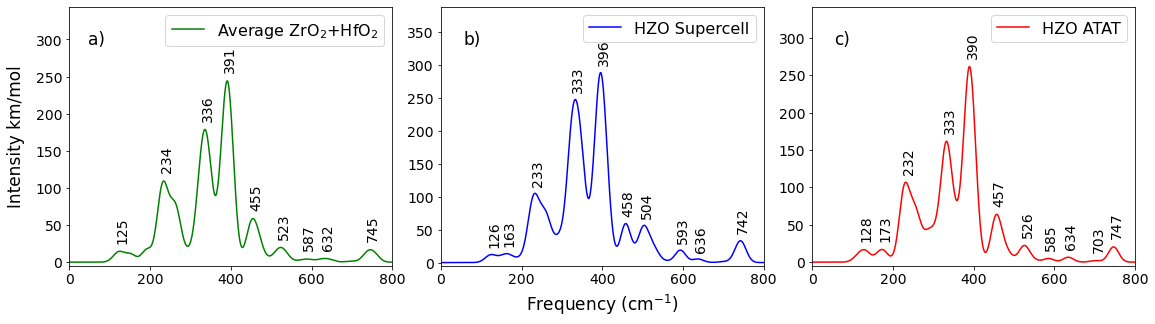

In [129]:
Average_ZrO2_HfO2_ortho29 = np.load("averageZrO2_HfO2_ortho29.npy")
Average_ZrO2_HfO2_ortho29[:, 1] = Average_ZrO2_HfO2_ortho29[:, 1]*2

wvn_Average_HZO_SC = (wvn_Average_HZO_112+wvn_Average_HZO_121+wvn_Average_HZO_211)/3
Int_Average_HZO_SC = (Int_Average_HZO_112+Int_Average_HZO_121+Int_Average_HZO_211)/3

# creating figure and axes
fig, ax = plt.subplots(nrows=1, ncols=3) #, sharey=True)

# white background to appears in dark jupyter theme
rect = fig.patch
rect.set_facecolor('white')

# creating a range of colors in rainbow style
colors = cm.rainbow(np.linspace(0, 1, 3))

# itarating over the files, colors and columns fot he figure

ax[0].plot(Average_ZrO2_HfO2_ortho29[:, 0], Average_ZrO2_HfO2_ortho29[:, 1], c='green', 
     label='Average ZrO$_2$+HfO$_2$')
ax[0].legend(fontsize=16)
ax[0].set_ylim(-5, max(Average_ZrO2_HfO2_ortho29[:, 1])+100)
ax[0].set_xlim(0, 800)

for peak in find_peaks(Average_ZrO2_HfO2_ortho29[:, 1])[0]:
    ax[0].annotate(str(round(Average_ZrO2_HfO2_ortho29[:, 0][peak])), 
                   xytext=(Average_ZrO2_HfO2_ortho29[:, 0][peak]-10, Average_ZrO2_HfO2_ortho29[:, 1][peak]+15), 
                   xy=(Average_ZrO2_HfO2_ortho29[:, 0][peak], Average_ZrO2_HfO2_ortho29[:, 1][peak]), fontsize=14, rotation=90) 
            

ax[1].plot(wvn_Average_HZO_SC, Int_Average_HZO_SC, c='blue', 
     label='HZO Supercell')
ax[1].legend(fontsize=16)
ax[1].set_ylim(-5, max(Int_Average_HZO_SC)+100)
ax[1].set_xlim(0, 800)

for peak in find_peaks(Int_Average_HZO_SC)[0]:
    ax[1].annotate(str(round(wvn_Average_HZO_SC[peak])), xytext=(wvn_Average_HZO_SC[peak]-10, Int_Average_HZO_SC[peak]+15), 
                     xy=(wvn_Average_HZO_SC[peak], Int_Average_HZO_SC[peak]), fontsize=14, rotation=90) 

ax[2].plot(HZO_ortho_24atoms.Frequency, HZO_ortho_24atoms.Raw_abs, c='red', 
     label='HZO ATAT')
ax[2].legend(fontsize=16)
ax[2].set_ylim(-5, max(HZO_ortho_24atoms.Raw_abs)+80)
ax[2].set_xlim(0, 800)
for peak in find_peaks(HZO_ortho_24atoms.Raw_abs)[0]:
    ax[2].annotate(str(round(HZO_ortho_24atoms.Frequency[peak])), 
                   xytext=(HZO_ortho_24atoms.Frequency[peak]-10, HZO_ortho_24atoms.Raw_abs[peak]+15), 
                   xy=(HZO_ortho_24atoms.Frequency[peak], HZO_ortho_24atoms.Raw_abs[peak]), fontsize=14, rotation=90) 

    
# fig.text(0.38, 0.92, 'Average HZO', fontsize = 17)
fig.text(0.5, -0.02, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.06, 0.5, 'Intensity km/mol', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 14})
fig.set_size_inches(18.5, 4.5)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.15, 
                    hspace=0)

# ax[0].annotate("a)", xy=(100, ))
fig.text(0.1202, 0.8, 'a)', ha='center', va='center', fontsize = 17)
fig.text(0.402, 0.8, 'b)', ha='center', va='center', fontsize = 17)
fig.text(0.68, 0.8, 'c)', ha='center', va='center', fontsize = 17)

fig.savefig("Average_HZO_all.png", bbox_inches="tight")

## ATAT SQS DFT Results Jan 2023
- HZO ortho 29 12 and 18 atoms (10 pairs)
- HZO mono11, mono14 and triclinic (about 13 paris, 36 atoms)

In [23]:
# Converting filenames
filenames = glob.glob('ATAT_DFT/Jan23/*.irspec')
print(filenames)

for file in filenames:
    base = os.path.splitext(file)[0]
    os.rename(file, base + ".txt")

filenames_txt = glob.glob('*.txt')

[]


**HZO ortho 29 - 12 and 18 atoms**

In [24]:
HZO_ortho29_12 = pd.read_csv('ATAT_DFT/Jan23/HZO_ATAT_ortho29_12atoms.txt', delim_whitespace=True, index_col=False, 
                    names=["Frequency", "Wavelength", 
                           "Raw_abs", "Classical_abs", 
                           "Rayleigh_scat1", "Rayleigh_scat2", 
                           "Reflec_x", "Reflec_y", "Reflec_z"], header=None)

HZO_ortho29_18 = pd.read_csv('ATAT_DFT/Jan23/HZO_ATAT_ortho29_18atoms.txt', delim_whitespace=True, index_col=False, 
                    names=["Frequency", "Wavelength", 
                           "Raw_abs", "Classical_abs", 
                           "Rayleigh_scat1", "Rayleigh_scat2", 
                           "Reflec_x", "Reflec_y", "Reflec_z"], header=None)

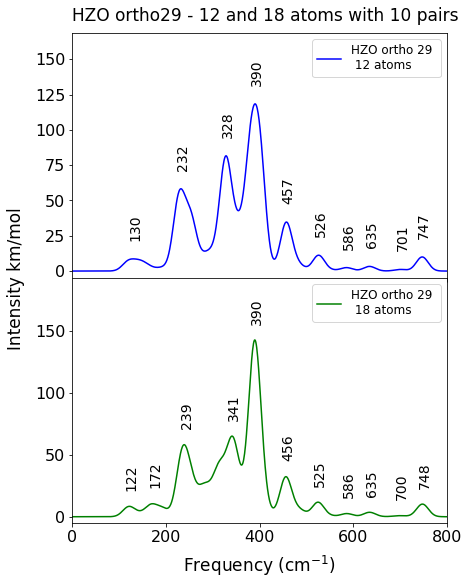

In [25]:
# creating figure and axes
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

# white background to appears in dark jupyter theme
rect = fig.patch
rect.set_facecolor('white')

# itarating over the files, colors and columns fot he figure

ax[0].plot(HZO_ortho29_12.Frequency, HZO_ortho29_12.Raw_abs, c='blue', 
     label='HZO ortho 29 \n 12 atoms')
ax[0].legend(fontsize=12)
ax[0].set_ylim(-5, max(HZO_ortho29_12.Raw_abs)+50)
ax[0].set_xlim(0, 800)

for peak in find_peaks(HZO_ortho29_12.Raw_abs)[0]:
    ax[0].annotate(str(round(HZO_ortho29_12.Frequency[peak])), xytext=(HZO_ortho29_12.Frequency[peak]-10, HZO_ortho29_12.Raw_abs[peak]+15), 
                     xy=(HZO_ortho29_12.Frequency[peak], HZO_ortho29_12.Raw_abs[peak]), fontsize=14, rotation=90) 
            

ax[1].plot(HZO_ortho29_18.Frequency, HZO_ortho29_18.Raw_abs, c='green', 
     label='HZO ortho 29 \n 18 atoms')
ax[1].legend(fontsize=12)
ax[1].set_ylim(-5, max(HZO_ortho29_18.Raw_abs)+50)

for peak in find_peaks(HZO_ortho29_18.Raw_abs)[0]:
    ax[1].annotate(str(round(HZO_ortho29_18.Frequency[peak])), xytext=(HZO_ortho29_18.Frequency[peak]-10, HZO_ortho29_18.Raw_abs[peak]+15), 
                     xy=(HZO_ortho29_18.Frequency[peak], HZO_ortho29_18.Raw_abs[peak]), fontsize=14, rotation=90) 

    
fig.text(0.1, 0.92, 'HZO ortho29 - 12 and 18 atoms with 10 pairs', fontsize = 17)
fig.text(0.5, 0.03, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(-0.02, 0.5, 'Intensity km/mol', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(6.5, 8.5)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0)


# fig.savefig(".png", bbox_inches="tight")

**HZO ATAT SQS all phases distance 12 Ang, 36 atoms: mono11, mono14, triclilnic**

In [50]:
filenames = glob.glob('ATAT_DFT/Jan23/ata*.txt')
print(filenames)

results = {}

for file in filenames:
    sample = pd.read_csv(file, delim_whitespace=True, index_col=False, 
                    names=["Frequency", "Wavelength", 
                           "Raw_abs", "Classical_abs", 
                           "Rayleigh_scat1", "Rayleigh_scat2", 
                           "Reflec_x", "Reflec_y", "Reflec_z"], header=None)
    results[file[-14:-4]] = sample
    
print(results.keys())

['ATAT_DFT/Jan23\\atat_HZO_SC_mono11.txt', 'ATAT_DFT/Jan23\\atat_HZO_SC_mono14.txt', 'ATAT_DFT/Jan23\\atat_HZO_SC_ortho29_24atoms.txt', 'ATAT_DFT/Jan23\\atat_HZO_SC_triclinic.txt']
dict_keys(['_SC_mono11', '_SC_mono14', '29_24atoms', '_triclinic'])


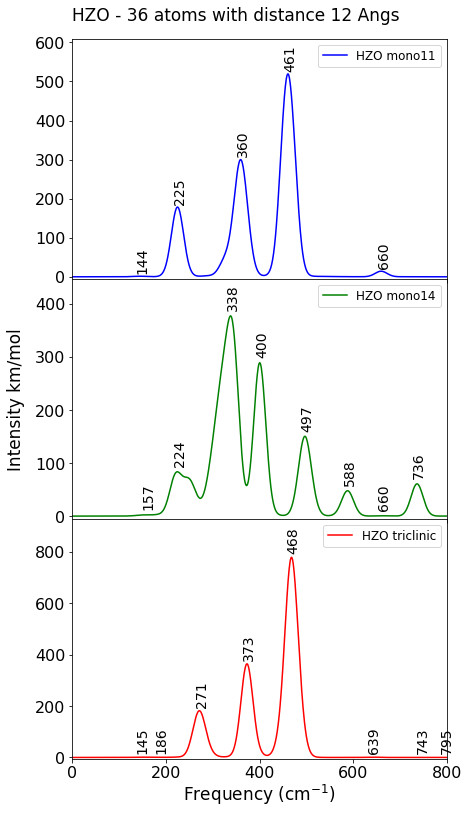

In [51]:
# creating figure and axes
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

# white background to appears in dark jupyter theme
rect = fig.patch
rect.set_facecolor('white')

# itarating over the files, colors and columns fot he figure

ax[0].plot(results['_SC_mono11'].Frequency, results['_SC_mono11'].Raw_abs, c='blue', 
     label='HZO mono11')
ax[0].legend(fontsize=12)
ax[0].set_ylim(-5, max(results['_SC_mono11'].Raw_abs)+90)
ax[0].set_xlim(0, 800)

for peak in find_peaks(results['_SC_mono11'].Raw_abs)[0]:
    ax[0].annotate(str(round(results['_SC_mono11'].Frequency[peak])), xytext=(results['_SC_mono11'].Frequency[peak]-10, results['_SC_mono11'].Raw_abs[peak]+15), 
                     xy=(results['_SC_mono11'].Frequency[peak], results['_SC_mono11'].Raw_abs[peak]), fontsize=14, rotation=90) 
            

ax[1].plot(results['_SC_mono14'].Frequency, results['_SC_mono14'].Raw_abs, c='green', 
     label='HZO mono14')
ax[1].legend(fontsize=12)
ax[1].set_ylim(-5, max(results['_SC_mono14'].Raw_abs)+70)

for peak in find_peaks(results['_SC_mono14'].Raw_abs)[0]:
    ax[1].annotate(str(round(results['_SC_mono14'].Frequency[peak])), xytext=(results['_SC_mono14'].Frequency[peak]-10, results['_SC_mono14'].Raw_abs[peak]+15), 
                     xy=(results['_SC_mono14'].Frequency[peak], results['_SC_mono14'].Raw_abs[peak]), fontsize=14, rotation=90) 

ax[2].plot(results['_triclinic'].Frequency, results['_triclinic'].Raw_abs, c='red', 
     label='HZO triclinic')
ax[2].legend(fontsize=12)
ax[2].set_ylim(-5, max(results['_triclinic'].Raw_abs)+150)

for peak in find_peaks(results['_triclinic'].Raw_abs)[0]:
    ax[2].annotate(str(round(results['_triclinic'].Frequency[peak])), xytext=(results['_triclinic'].Frequency[peak]-10, results['_triclinic'].Raw_abs[peak]+25), 
                     xy=(results['_triclinic'].Frequency[peak], results['_triclinic'].Raw_abs[peak]), fontsize=14, rotation=90)
 


fig.text(0.1, 0.92, 'HZO - 36 atoms with distance 12 Angs', fontsize = 17)
fig.text(0.5, 0.06, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(-0.02, 0.5, 'Intensity km/mol', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(6.5, 12.5)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0)


# fig.savefig(".png", bbox_inches="tight")

### Mix HZO SQS Mono14 + Ortho29

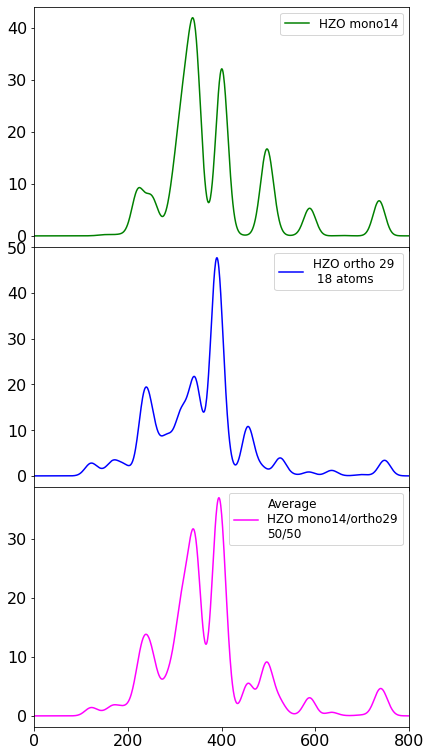

In [52]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

# HZO SQS mono14 36 atoms
ax[0].plot(results['_SC_mono14'].Frequency, (results['_SC_mono14'].Raw_abs)/9, c='green', 
     label='HZO mono14')
ax[0].legend(fontsize=12)
ax[0].set_xlim(0, 800)

# HZO SQS ortho29 18 atoms (actually 12 in unit cell)
ax[1].plot(HZO_ortho29_18.Frequency, (HZO_ortho29_18.Raw_abs)/3, c='blue', 
     label='HZO ortho 29 \n 18 atoms')
ax[1].legend(fontsize=12)

# Average of both HZO mono14 + ortho29 for 50/50
av = ((results['_SC_mono14'].Raw_abs)/9 + (HZO_ortho29_18.Raw_abs)/3)/2
ax[2].plot(results['_SC_mono14'].Frequency, av, c='magenta', 
     label='Average\nHZO mono14/ortho29\n50/50')
ax[2].legend(fontsize=12)


fig.set_size_inches(6.5, 12.5)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0)

Text(0.02, 0.5, 'Intensity km/mol')

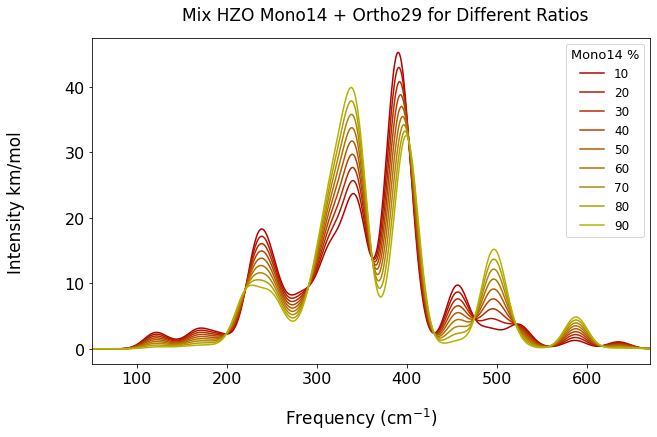

In [119]:
ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

darker = 0.7

mono14_norm = (results['_SC_mono14'].Raw_abs)/9
ortho29_norm = (HZO_ortho29_18.Raw_abs)/3
wvn = results['_SC_mono14'].Frequency

colors = plt.cm.autumn(np.linspace(0, 1, 9))

fig, ax = plt.subplots() #nrows=3, ncols=1, sharex=True)

for i, j in zip(ratios, colors):
#     print(i)
    # Average of both HZO mono14 + ortho29 for 50/50
    av = mono14_norm*i + ortho29_norm*(1-i)
    ax.plot(wvn, av, c=adjust_lightness(j, darker), 
         label=round(i*100))
    
ax.set_xlim(50, 670)
ax.legend(fontsize=12, title='Mono14 %',  title_fontsize= 13)
fig.set_size_inches(10, 6)

fig.text(0.25, 0.92, 'Mix HZO Mono14 + Ortho29 for Different Ratios', fontsize = 17)
fig.text(0.5, 0, 'Frequency (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.02, 0.5, 'Intensity km/mol', ha='center', va='center', rotation='vertical', fontsize = 17)

# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.2, 
#                     hspace=0)

**Plotting the HZO Exp with the same graph formating to compare**

HZO_exp_to_compare\HZO_10_RT.txt not norm
HZO_exp_to_compare\HZO_11_RT.txt not norm
HZO_exp_to_compare\HZO_17_RT.txt not norm
HZO_exp_to_compare\HZO_21_RT.txt not norm
HZO_exp_to_compare\HZO_23_RT.txt not norm
HZO_exp_to_compare\HZO_52_RT.txt not norm


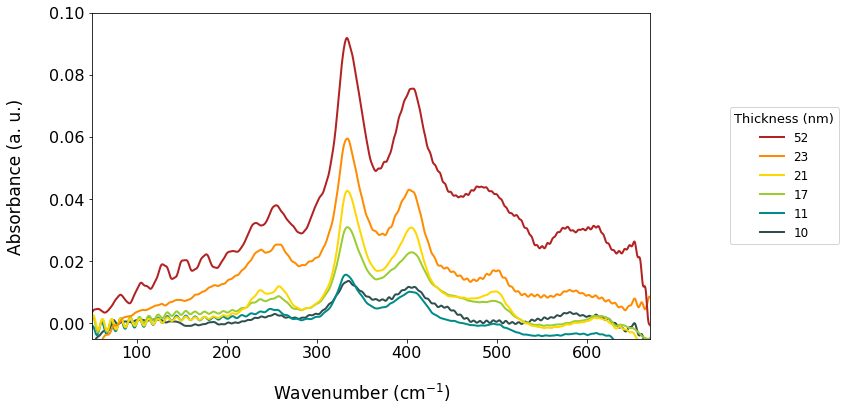

In [117]:
filenames_HfO2_exp = glob.glob('HZO_exp_to_compare/HZO*_RT.txt')
# print(filenames_HfO2_exp)
filenames_HfO2_exp.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

#print(filenames_HfO2)

n = len(filenames_HfO2_exp)

# fig, ax = plt.subplots(len(filenames_HfO2_exp),1)
fig, ax = plt.subplots()

d_HZO = {}
d_HZO_norm= {}

# cmap = plt.get_cmap('hsv')

colors = ['darkslategray', 'darkcyan', 'yellowgreen', 'gold', 'darkorange', 'firebrick']
# colors = cmap(np.linspace(0.2,1,n)) 
#cm.rainbow(np.linspace(0, 1, n))

for i, j, z in zip(filenames_HfO2_exp, colors, range(len(filenames_HfO2_exp))):

    space_group = pd.read_csv(i, delim_whitespace=True, index_col=False, 
                names=["Frequency", "Absorbance"], header=None)
    d_HZO[i] = space_group
    
    #Put all absorbance postive (shift the curves)
    if i[4:6]  == '10':
        print(i, 'norm')
        I_min = space_group['Absorbance'][50:].min()
        I_pos = space_group['Absorbance']-(I_min+0.005)

        ax.plot(space_group.Frequency, I_pos, linewidth=1.8, label=i[4:6], 
                   color=j, marker=',')
    elif i[4:6] in ['11', '17', '21', '23']:
        print(i, 'norm')
        I_min = space_group['Absorbance'][50:].min()
        I_pos = space_group['Absorbance']-I_min

        ax.plot(space_group.Frequency, I_pos, linewidth=1.8, label=i[4:6], 
                   color=j, marker=',')
                
    elif i[4] == '6':
        print(i, 'not norm')
        ax.plot(space_group.Frequency, space_group.Absorbance, linewidth=2, label=i[4], 
                   color=j)
    else:
        print(i, 'not norm')
        ax.plot(space_group.Frequency, space_group.Absorbance, linewidth=2, label=i[-9:-7], 
                   color=j)    
        
#get handles and labels
handles, labels = ax.get_legend_handles_labels()

#specify order of items in legend
order = sorted(range(0, n), reverse=True)

    #add legend to plot
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
          loc='right', bbox_to_anchor=(1.35, 0.5), title = "Thickness (nm)", fontsize = 12, title_fontsize=13)
# ax.legend(bbox_to_anchor=(1.22,0.5), loc='center right')
    
# bbox_to_anchor=(1.5, 1)
ax.set_ylim(-0.005, 0.1)
ax.set_xlim(50, 670)



fig.text(0.5, 0, 'Wavenumber (cm$^{-1}$)', ha='center', va='center', fontsize = 17)
fig.text(0.02, 0.5, 'Absorbance (a. u.)', ha='center', va='center', rotation='vertical', fontsize = 17)
plt.rcParams.update({'font.size': 16})
fig.set_size_inches(10, 6)

# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.4, 
#                     hspace=0.4)

# fig.savefig("Fig_Thickness.png", bbox_inches="tight")

## DRX DFT

In [3]:
ZrO2_DRX = pd.read_csv("DRX/ZrO2_TZVP_sp29_3.txt", delim_whitespace=True, index_col=False, 
                names=["2THETA", "INTENS", 
                       "INTENS-LP", "INTENS-LP-DW"], header=None)
ZrO2_DRX

,2THETA,INTENS,INTENS-LP,INTENS-LP-DW
0,0.00,0.00,0.00,0.00
1,0.23,0.00,0.00,0.00
2,0.45,0.00,0.00,0.00
3,0.68,0.00,0.00,0.00
4,0.90,0.00,0.00,0.00
...,...,...,...,...
395,88.87,739.65,132.11,107.43
396,89.10,244.72,43.70,35.54
397,89.32,37.39,6.69,5.44
398,89.55,19.85,3.55,2.89


Text(0, 0.5, 'Intensity')

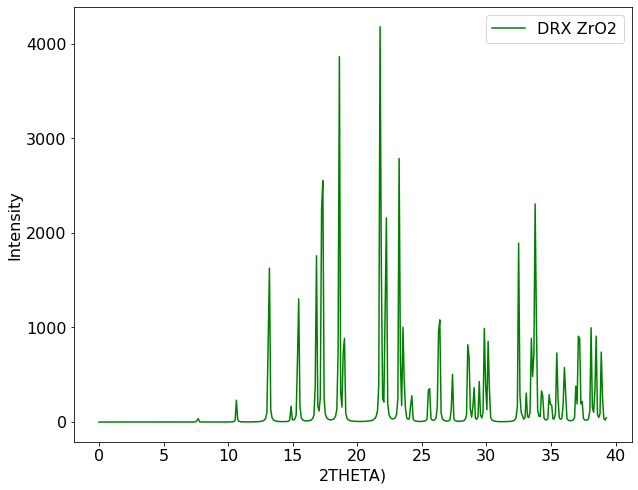

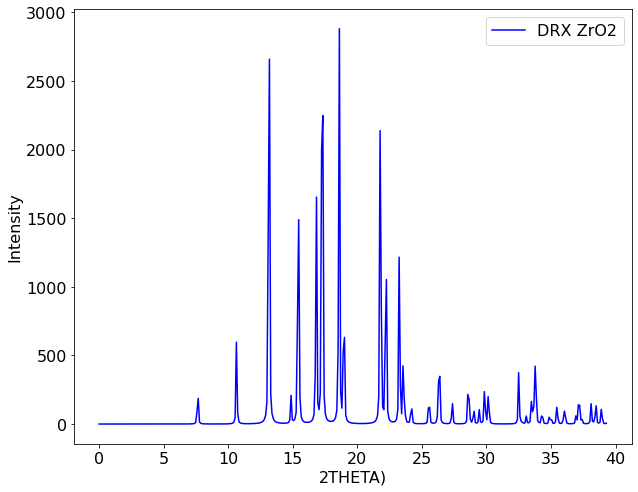

In [11]:
# plotting
fig, ax = plt.subplots(figsize=[10, 8])
ax.plot(ZrO2_DRX["2THETA"]*(0.674/1.54), ZrO2_DRX["INTENS"], c='green', 
         label='DRX ZrO2')
ax.legend(fontsize=16)
ax.set_xlabel('2THETA)', fontsize=16)
ax.set_ylabel('Intensity', fontsize=16)
# ax.set_ylim(-5, max(Int_Average_HZO_211)+60)

fig2, ax2 = plt.subplots(figsize=[10, 8])
ax2.plot(ZrO2_DRX["2THETA"]*(0.674/1.54), ZrO2_DRX["INTENS-LP-DW"], c='blue', 
         label='DRX ZrO2')
ax2.legend(fontsize=16)
ax2.set_xlabel('2THETA)', fontsize=16)
ax2.set_ylabel('Intensity', fontsize=16)
# ax.set_ylim(-5, max(Int_Average_HZO_211)+60)

In [12]:
filenames = glob.glob("DRX/*.npy")
HZO_DRX_raw = {}
for file in filenames:
    HZO_DRX_raw[file[:-4]] = np.load(file)

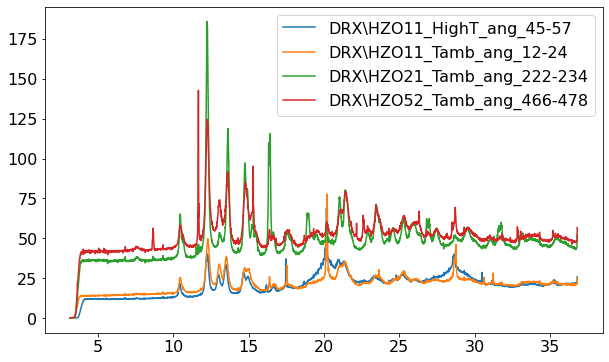

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

# white background to appears in dark jupyter theme
rect = fig.patch
rect.set_facecolor('white')

for k in HZO_DRX_raw.keys():
    ax.plot(HZO_DRX_raw[k][:,0], HZO_DRX_raw[k][:,1], label=k)
plt.legend() 

Text(0, 0.5, 'Intensity')

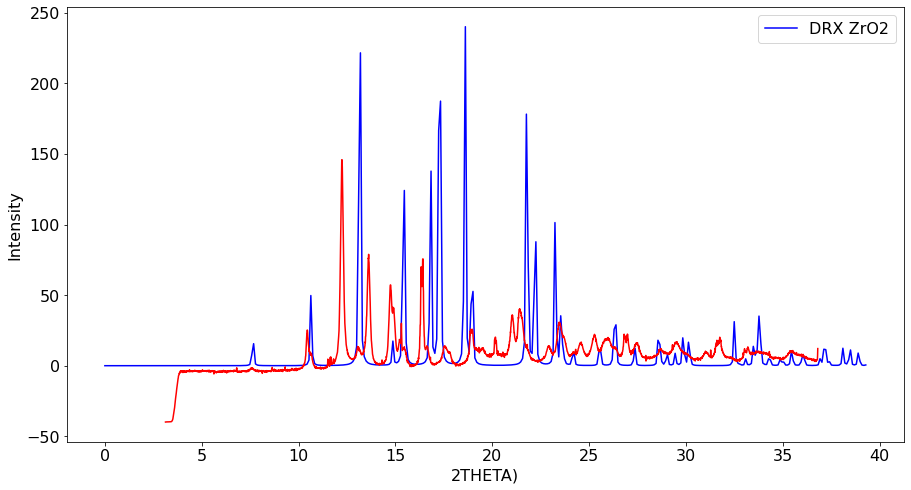

In [21]:
fig2, ax2 = plt.subplots(figsize=[15, 8])
ax2.plot(ZrO2_DRX["2THETA"]*(0.674/1.54), ZrO2_DRX["INTENS-LP-DW"]/12, c='blue', 
         label='DRX ZrO2')
ax2.plot(HZO_DRX_raw['DRX\\HZO21_Tamb_ang_222-234'][:,0], HZO_DRX_raw['DRX\\HZO21_Tamb_ang_222-234'][:,1]-40, c='red')
ax2.legend(fontsize=16)
ax2.set_xlabel('2THETA)', fontsize=16)
ax2.set_ylabel('Intensity', fontsize=16)
# ax.set_ylim(-5, max(Int_Average_HZO_211)+60)